In [7]:
install.packages('afex')
install.packages('emmeans')
install.packages('Hmisc')
install.packages('dfoptim')
install.packages('zoo')
install.packages('reshape2')
install.packages('forcats')
install.packages('lemon')
install.packages("buildmer")
install.packages("performance")
install.packages("janitor")
install.packages("broom.mixed")
install.packages("lmerTest")
install.packages("pbkrtest")
install.packages("MuMIn")
install.packages("codingMatrices")
install.packages("BayesFactor")
install.packages("brms")
install.packages("effects")
install.packages("ggeffects")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Inst

In [14]:
# Load packages

# Data processing and plotting
library(magrittr)
library(plyr)
library(tidyverse)
library(lattice)
library(gridExtra)
library(data.table)

# Simple models
library(car)
library(janitor)

# Mixed-effects modeling
library(afex)
library(emmeans)
library(lme4)
library(MuMIn)
library(buildmer)
library(broom.mixed)

# Bayesian models
library(brms)
library(bayestestR)
library(BayesFactor)

# Assess models and results
library(effects)
library(ggeffects)
library(performance)
library(knitr)

In [15]:
# Save defaults
graphical_defaults <- par()
options_defaults <- options() 

# 0. Prepare data

In [23]:
system('gdown --id 1C7pJY0K7YfJThSQnaUfLClJVK9Pvw3dG')
data <- read_csv('dataActionFPAll.csv')

New names:
• `` -> `...1`
Rows: 7680 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): ID, date, condition, orientation, corrAns, Response.keys, counterb...
dbl (11): ...1, Acc, block, foreperiod, RT, action_trigger.rt, extFixationDu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
# Some helper functions
# 1. "not in" operator
'%!in%' <- function(x,y)!('%in%'(x,y))


# 2. Compute z-score
compute_zscore <- function(x) {
  z_score <- (x-mean(x))/sd(x)
}

In [24]:
# Remove unnecessary columns
data <- data %>%
  dplyr::select(ID, Acc, condition, block, orientation,
                foreperiod, RT, counterbalance, 
                extFixationDuration, action_trigger.rt,
                oneBackFP, twoBackFP, oneBackEffect) %>%
  mutate(foreperiod = foreperiod * 1000,
         RT = RT *1000,
         extFixationDuration = extFixationDuration * 1000,
         action_trigger.rt = action_trigger.rt * 1000,
         oneBackFP = oneBackFP * 1000,
         twoBackFP = twoBackFP * 1000,
         oneBackEffect = oneBackEffect * 1000)

# Coerce to factors
data$ID <- as.factor(data$ID)
data$condition <- data$condition %>%
  as.factor() %>%
  forcats::fct_relevel(c("external", "action"))
data$block <- as.factor(data$block)
data$orientation <- as.factor(data$orientation)
data$foreperiod <- as.factor(data$foreperiod)
data$counterbalance <- as.factor(data$counterbalance)
data$oneBackFP <- as.factor(data$oneBackFP)
data$twoBackFP <- as.factor(data$twoBackFP)

# Create numeric versions of foreperiod and FP n-1
data$numForeperiod <- as.numeric(as.character(data$foreperiod))
data$numOneBackFP <- as.numeric(as.character(data$oneBackFP))

# Remove practice trials
data <- data %>%
  filter(condition != 'practice')

# Create column for difference between current and previous FP as a numeric variable:
#oneBackFPDiff <- diff(as.numeric(as.character(data$foreperiod)))
#oneBackFPDiff <- c(NA, oneBackFPDiff)
#data$numOneBackFPDiff <- oneBackFPDiff

data <- data %>%
  group_by(ID, block) %>%
  mutate(numOneBackFPDiff = c(NA, diff(numForeperiod))) %>%
  mutate(oneBackFPDiff = as.factor(numOneBackFPDiff)) %>% # to summarise RTs according to value of FP n-1
  ungroup()

# Create column for previous orientation
data <- data %>%
  mutate(prevOri = ifelse(lag(orientation)==orientation, 'same', 'different')) %>%
  mutate(prevOri = as.factor(prevOri))
  

# Remove trials without n-1 FP values (i.e., first of each block)
data <- data %>%
  filter(!is.na(oneBackFP), !is.na(twoBackFP))
#filter(!is.na(oneBackFP))

# Keep only go trials with correct responses to analyze RT
data <- data %>%
  filter(!is.na(RT), Acc == 1)

# Create log10 of continuous indenpendent variables
data$numLogFP <- log10(data$numForeperiod)
data$logFP <- as.factor(data$numLogFP)
data$logOneBackFP <- log10(data$numOneBackFP)

# Remove extreme values
data <- data %>%
  #filter(RT < 1.0) %>%
  #filter(RT > 0.15)
  filter(RT < 1000) %>%
  filter(RT > 150)

# Transform RT to reduce skew
data$logRT <- ifelse(!is.na(data$RT), log10(data$RT), NA) # log-transform
data$invRT <- ifelse(!is.na(data$RT), 1/data$RT, NA)

# Trimming
data2 <- data %>%
  group_by(ID) %>%
  mutate(RTzscore=ifelse(!is.na(RT), compute_zscore(RT), NA),
         logRTzscore=ifelse(!is.na(RT), compute_zscore(logRT), NA)) %>%
  filter(abs(logRTzscore) < 3) %>%
  ungroup()

# No trimming
data <- data %>%
  group_by(ID) %>%
  mutate(RTzscore=ifelse(!is.na(RT), compute_zscore(RT), NA),
         logRTzscore=ifelse(!is.na(RT), compute_zscore(logRT), NA)) %>%
  #filter(abs(logRTzscore) < 3) %>%
  ungroup()


# Average data
summaryData <- data %>%
  group_by(ID,foreperiod,condition,
           orientation,prevOri,
           oneBackFP,twoBackFP,oneBackFPDiff,
           block,counterbalance) %>%
  summarise(meanRT = mean(RT),
            meanLogRT = mean(logRT),
            meanRTzscore = mean(RTzscore),
            meanInvRT = mean(invRT),
            meanSeqEff = mean(oneBackEffect)) %>%
  ungroup() %>%
  mutate(numForeperiod=as.numeric(as.character(foreperiod)),
          logNumForeperiod=log10(numForeperiod),
         numOneBackFPDiff=as.numeric(as.character(oneBackFPDiff)),
         logNumOneBackFPDiff=log10(numOneBackFPDiff))

summaryData2 <- data2 %>%
  group_by(ID,foreperiod,condition,
           orientation,prevOri,
           oneBackFP,twoBackFP,oneBackFPDiff,
           block,counterbalance) %>%
  summarise(meanRT = mean(RT),
            meanLogRT = mean(logRT),
            meanRTzscore = mean(RTzscore),
            meanInvRT = mean(invRT),
            meanSeqEff = mean(oneBackEffect)) %>%
  ungroup() %>%
  mutate(numForeperiod=as.numeric(as.character(foreperiod)),
         logNumForeperiod=log10(numForeperiod),
         numOneBackFPDiff=as.numeric(as.character(oneBackFPDiff)),
         logNumOneBackFPDiff=log10(numOneBackFPDiff))


`summarise()` has grouped output by 'ID', 'foreperiod', 'condition',
'orientation', 'prevOri', 'oneBackFP', 'twoBackFP', 'oneBackFPDiff', 'block'.
You can override using the `.groups` argument.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `logNumOneBackFPDiff = log10(numOneBackFPDiff)`.
Caused by warning:
! NaNs produced”
`summarise()` has grouped output by 'ID', 'foreperiod', 'condition',
'orientation', 'prevOri', 'oneBackFP', 'twoBackFP', 'oneBackFPDiff', 'block'.
You can override using the `.groups` argument.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `logNumOneBackFPDiff = log10(numOneBackFPDiff)`.
Caused by warning:
! NaNs produced”


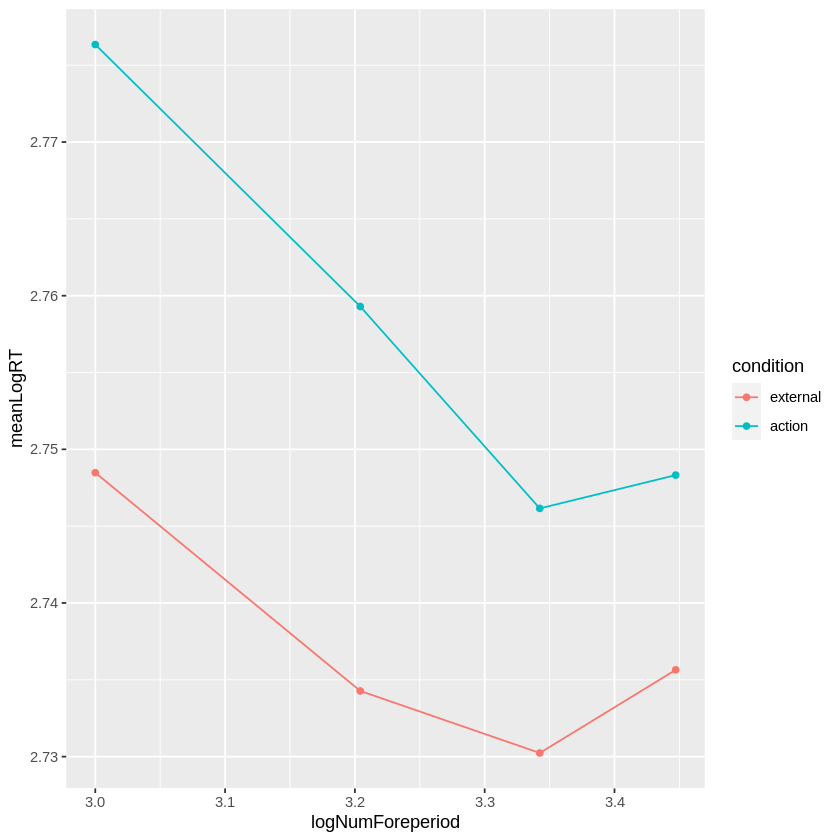

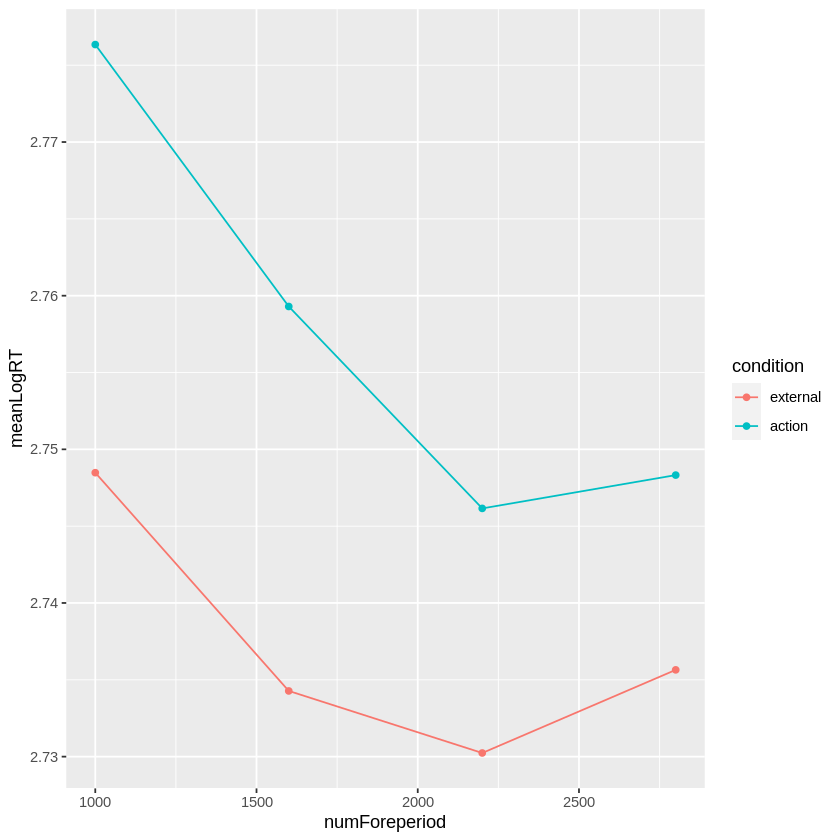

In [ ]:
ggplot(data=summaryData2,
aes(x=logNumForeperiod,
y=meanLogRT,
color=condition)) +
  stat_summary(fun='mean',geom='point') +
  stat_summary(fun='mean',geom='line',aes(group=condition))

ggplot(data=summaryData2,
aes(x=numForeperiod,
y=meanLogRT,
color=condition)) +
  stat_summary(fun='mean',geom='point') +
  stat_summary(fun='mean',geom='line',aes(group=condition))
  

#1. Data quality

In [ ]:
system('gdown --id 1DQhMEGBbYz24-re_Xxi_fXRPIdgZ8j10')
dataQuality <- read_delim('data_quality.csv', delim = ";")
View(dataQuality)

New names:
• `` -> `...1`
Rows: 21 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (6): ...1, participant, errorRateAll, errorRateLeft, errorRateRight, tri...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,participant,errorRateAll,errorRateLeft,errorRateRight,trimmedRTRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2,0.6250,0.000,1.250,0
1,3,1.5625,3.125,0.000,0
2,4,4.0625,1.875,6.250,0
3,5,1.8750,0.625,3.125,0
4,6,1.5625,1.250,1.875,0
5,8,5.6250,5.000,6.250,0
6,9,5.0000,4.375,5.625,0
7,10,0.6250,0.625,0.625,0
8,11,0.3125,0.000,0.625,0


Two participants have error rates greater than 10%, so we exclude those. (Actually, the data we imported already excluded those participants).

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


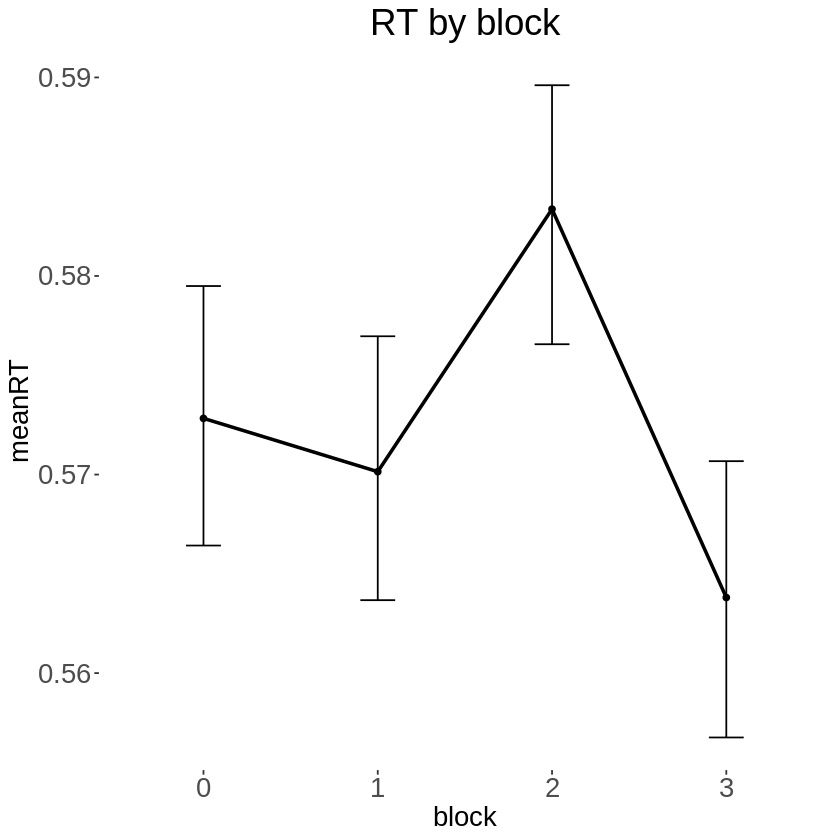

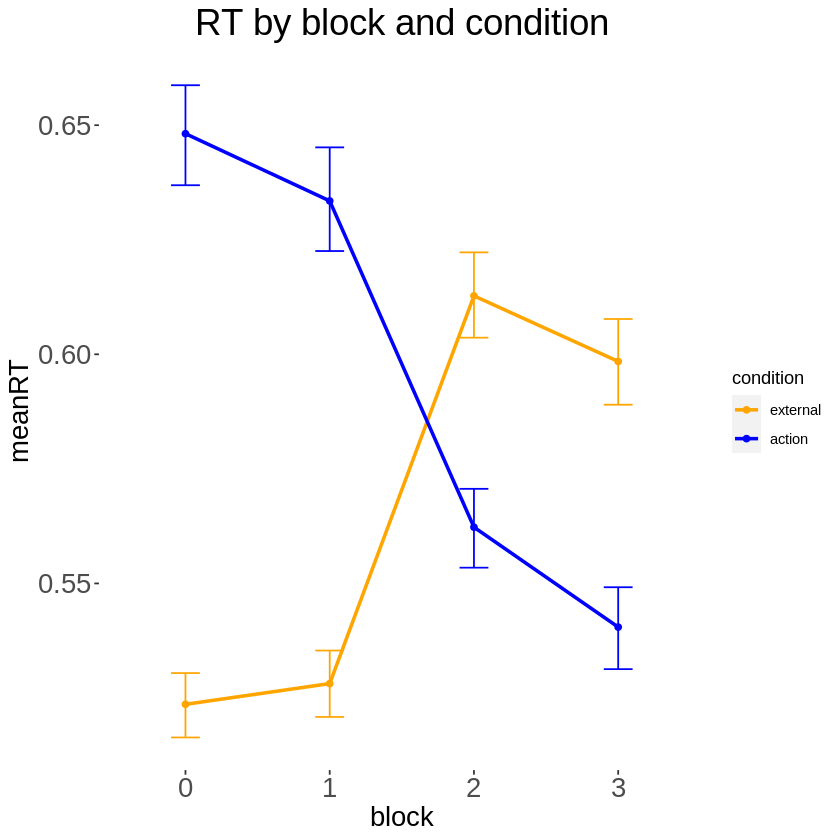

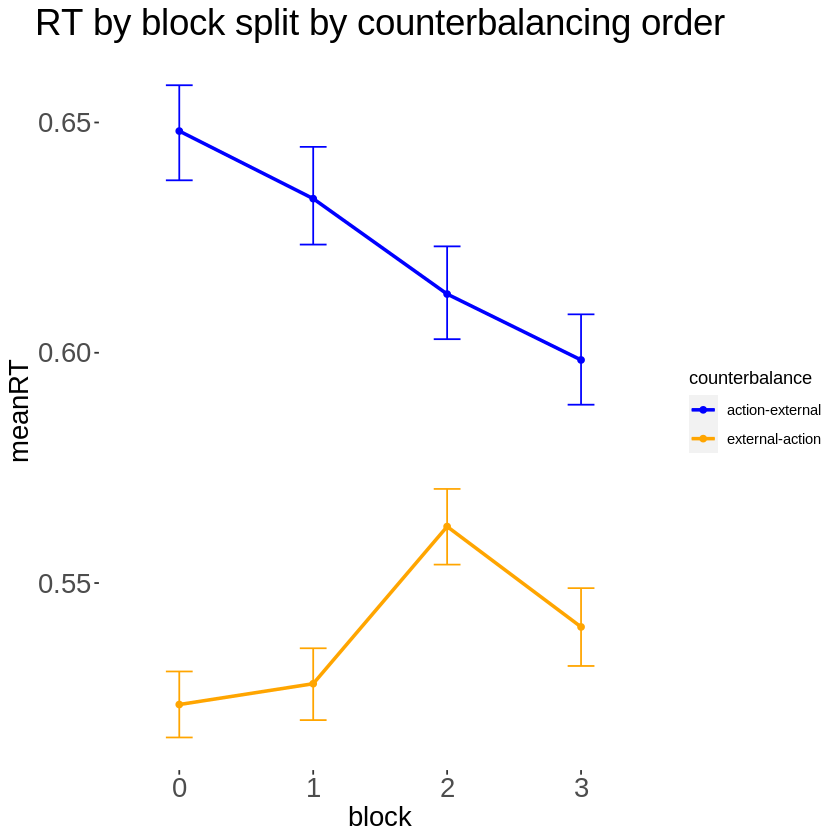

In [ ]:
# 1.1.1. RTs across blocks (conditions aggregated)
ggplot(data=summaryData,
       aes(x=block,
           y=meanRT))+
  stat_summary(fun='mean',geom='point')+
  stat_summary(fun='mean',geom='line',size=1,aes(group=1))+
  stat_summary(fun.data='mean_cl_boot',width=0.2,geom='errorbar')+
  theme(plot.title=element_text(size = rel(2), hjust = 0.5),
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank(),
        panel.background=element_blank(),
        axis.text = element_text(size = rel(1.5)),
        axis.title = element_text(size = rel(1.5)))+
  labs(title='RT by block')

# 1.1.2. RTs across blocks (separated by condition)
ggplot(data=summaryData,
       aes(x=block,
           y=meanRT,
           color=condition))+
  stat_summary(fun='mean',geom='point')+
  stat_summary(fun='mean',geom='line',size=1,aes(group=condition))+
  stat_summary(fun.data='mean_cl_boot',width=0.2,geom='errorbar')+
  theme(plot.title=element_text(size = rel(2), hjust = 0.5),
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank(),
        panel.background=element_blank(),
        axis.text = element_text(size = rel(1.5)),
        axis.title = element_text(size = rel(1.5)))+
  scale_color_manual(values=c('orange','blue')) +
  labs(title='RT by block and condition')

# 1.1.3. RTs across blocks by counterbalancing order
ggplot(data=summaryData,
       aes(x=block,
           y=meanRT,
           color=counterbalance))+
  stat_summary(fun='mean',geom='point')+
  stat_summary(fun='mean',geom='line',size=1,aes(group=counterbalance))+
  stat_summary(fun.data='mean_cl_boot',width=0.2,geom='errorbar')+
  theme(plot.title=element_text(size = rel(2), hjust = 0.5),
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank(),
        panel.background=element_blank(),
        axis.text = element_text(size = rel(1.5)),
        axis.title = element_text(size = rel(1.5)))+
  scale_color_manual(values=c('blue','orange')) +
  labs(title='RT by block split by counterbalancing order')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


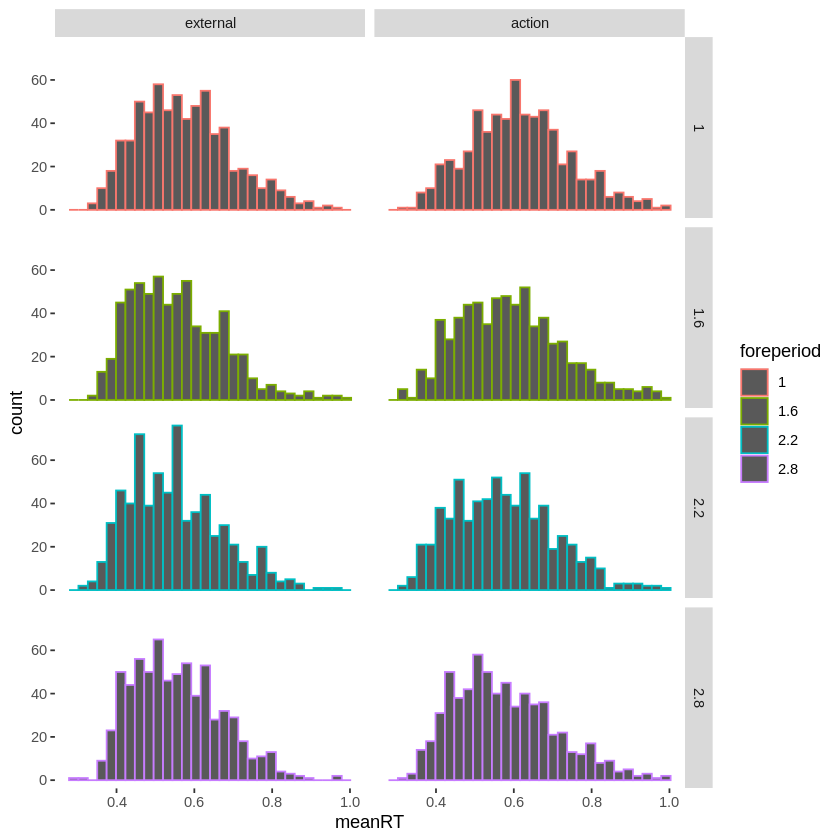

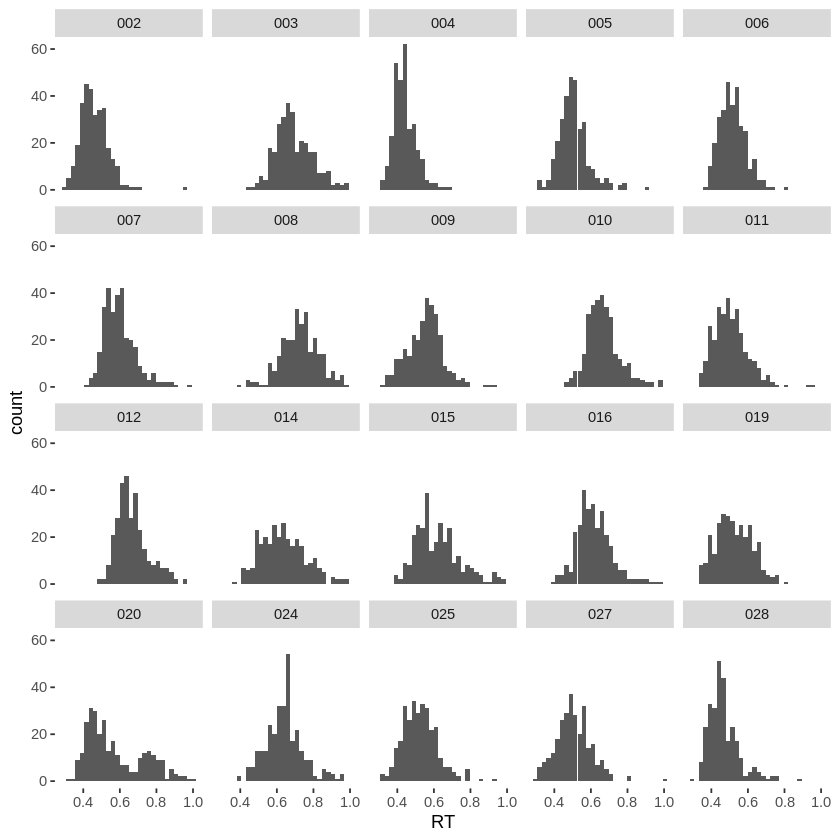

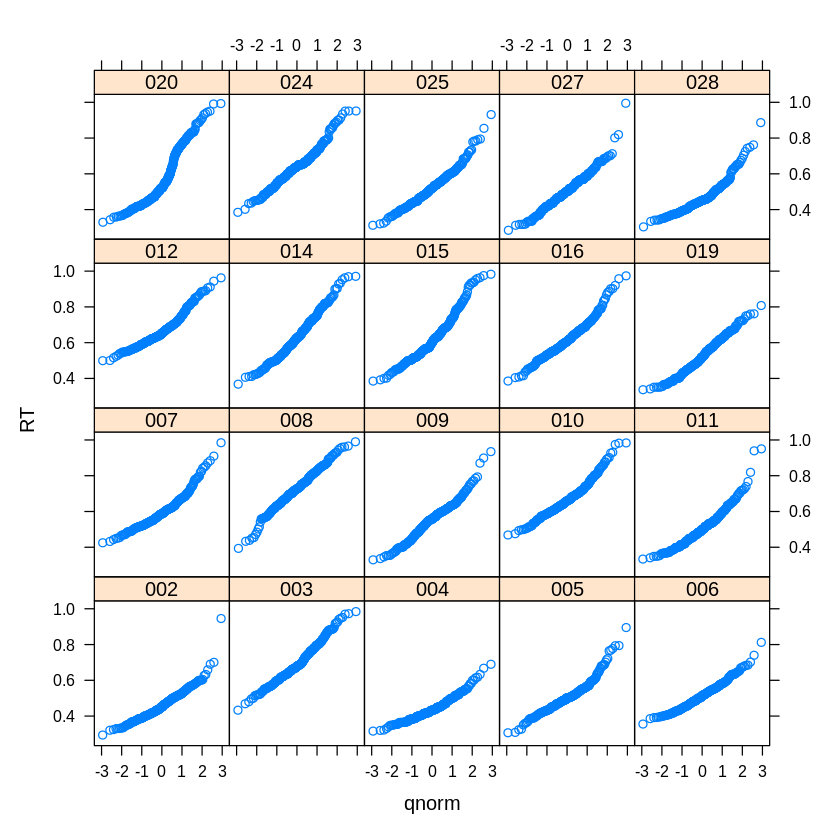

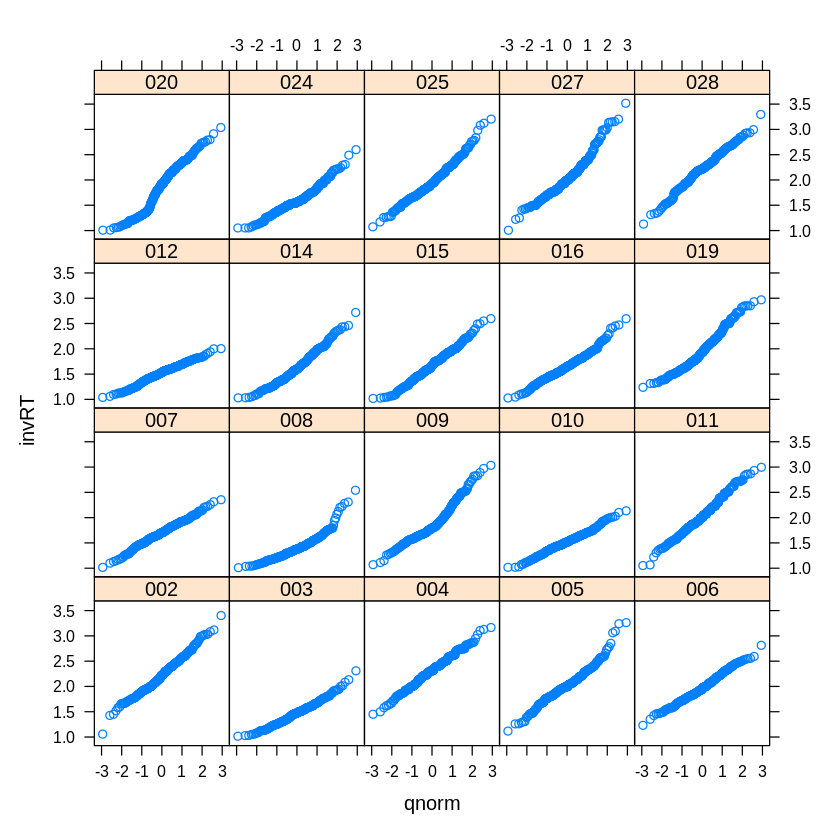

In [ ]:
# Distribution of data
dataHists <- ggplot(data=summaryData,
                    aes(x=meanRT,
                        color=foreperiod))+
  geom_histogram()+
  facet_grid(foreperiod~condition)+
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank())
dataHists

# Individual histograms
indHistograms <- ggplot(data=data,
                        aes(x=RT))+
  geom_histogram()+
  facet_wrap(~ID)+
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank())
indHistograms

qqmath(~RT|ID, data=data)
qqmath(~invRT|ID, data=data)

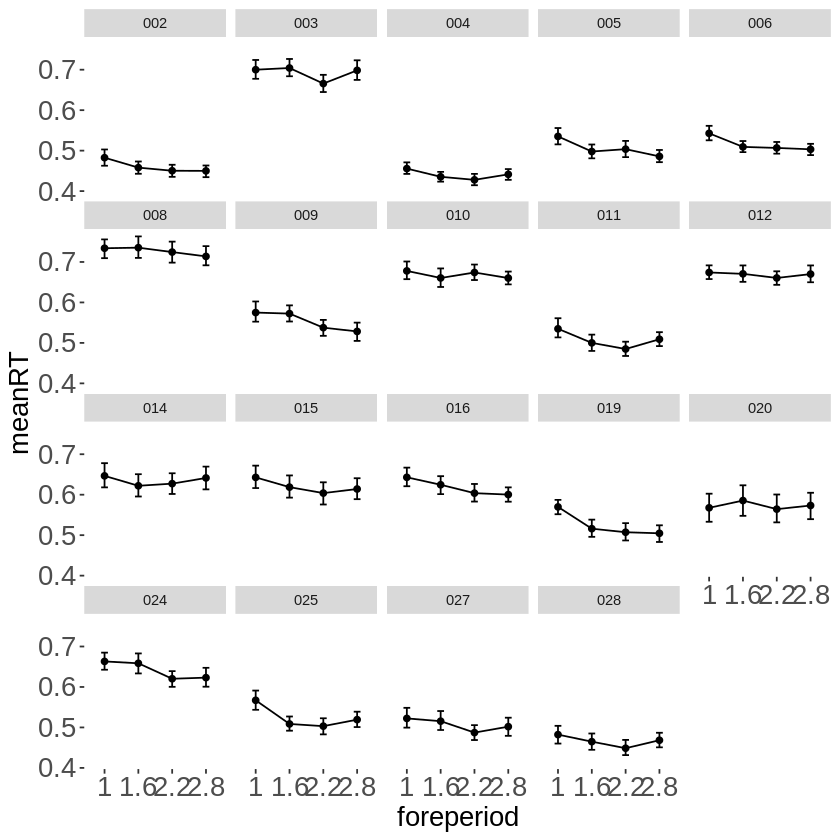

In [ ]:
# 1.4.1. Plot RT by foreperiod only
ggplot(data = summaryData,
       aes(x = foreperiod,
           y = meanRT,
           group = 1)) +
  stat_summary(fun = 'mean', geom = 'point') +
  stat_summary(fun = 'mean', geom = 'line' ) +
  stat_summary(fun.data = 'mean_cl_boot', width = 0.2, geom = 'errorbar') +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.text = element_text(size = rel(1.5)),
        axis.title = element_text(size = rel(1.5))) +
  facet_wrap(~ID)

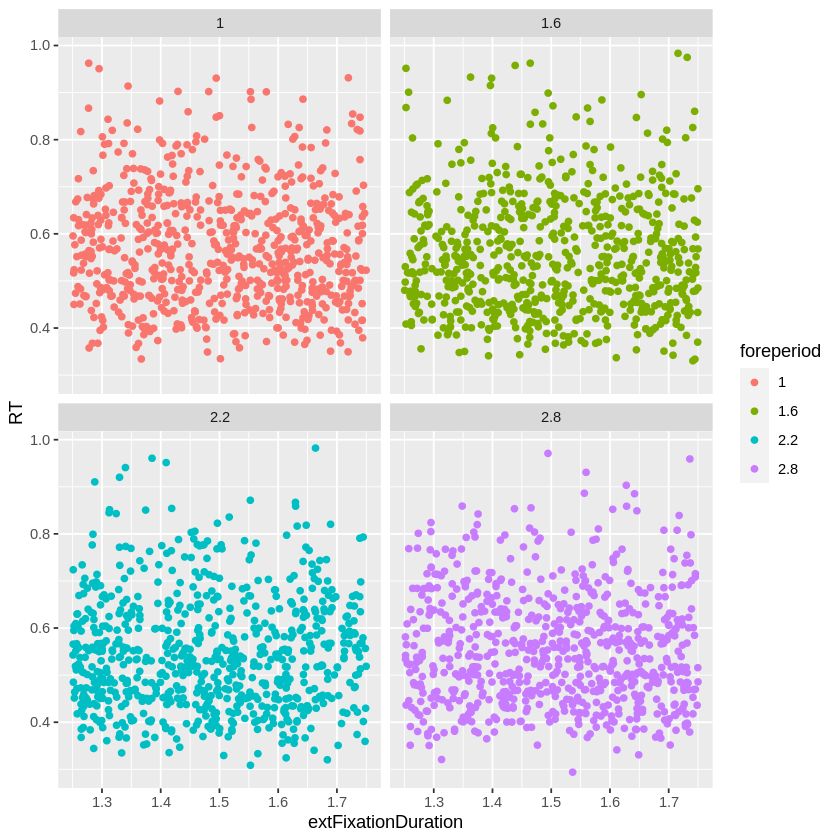

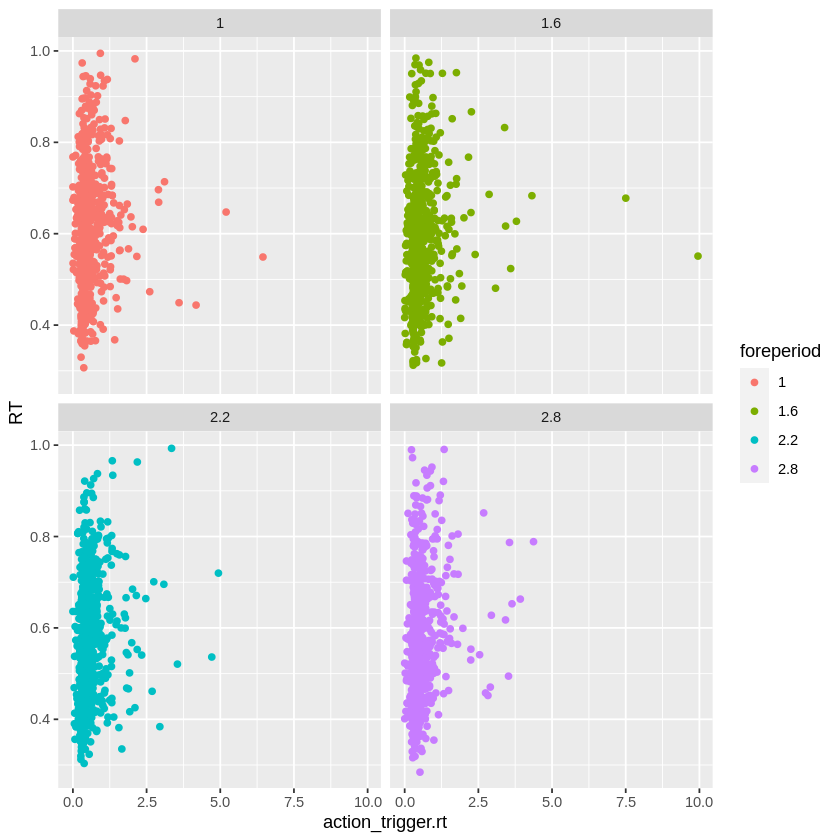

In [ ]:
# Check for influence of external fixation duration
ggplot(data=filter(data,condition=='external'),
       aes(x=extFixationDuration,
           y=RT,
           color=foreperiod))+
  geom_point() +
  facet_wrap(~foreperiod)

# Check for influence of latency of action key press on RT
ggplot(data=filter(data,condition=='action'),
       aes(x=action_trigger.rt,
           y=RT,
           color=foreperiod))+
  geom_point() +
  facet_wrap(~foreperiod)

## 1.2. Stopping-rule

Here, we check whether data collection can stop with the current n. We use three methods:


1.   First, we fit linear models separately for participant and condition and run bayesian t-tests on the parameters for each condition to assess, using bayes factors, if there is evidence in the direction of either the null hypothesis or the alternative hypothesis.
2.   Second, we fit linear mixed models to the data. Specifically, we fit two models: one including FP n-1 as a predictor, and the other not including it. We then transform the BICs for the model comparison to bayes factors.
3.   Third, we update bayes factors sequentially for each predictor as participants are included in the sample



### 1.2.1. Using individual linear models

Variables used as predictors: numForeperiod and numOneBackFP

Dependent variable: logRT

Variables nested by condition and ID

In [ ]:
buildmodel <- function(data) {
  lm(logRT ~ numForeperiod*numOneBackFP,
     data = data)
}

nested_data <- data2 %>%
  select(ID, condition, numForeperiod, numOneBackFP, logRT) %>%
  group_by(ID, condition) %>%
  nest()

fitted_data <- nested_data %>%
  mutate(fit = map(data, buildmodel),
         params = map(fit, tidy)) %>%
  ungroup() %>%
  unnest(c(params)) %>%
  select(ID, condition, term, estimate) %>%
  pivot_wider(names_from = term,
              values_from = estimate)
  

# Foreperiod
fp_bfs <- ttestBF(x = fitted_data$numForeperiod[fitted_data$condition=='external'],
        y = fitted_data$numForeperiod[fitted_data$condition=='action'],
        paired=TRUE)

onebackfp_bfs <- ttestBF(x = fitted_data$numOneBackFP[fitted_data$condition=='external'],
        y = fitted_data$numOneBackFP[fitted_data$condition=='action'],
        paired=TRUE)

interact_bfs <- ttestBF(x = fitted_data$`numForeperiod:numOneBackFP`[fitted_data$condition=='external'],
        y = fitted_data$`numForeperiod:numOneBackFP`[fitted_data$condition=='action'],
        paired=TRUE)


In [ ]:
fp_bfs


Bayes factor analysis
--------------
[1] Alt., r=0.707 : 6.276983 ±0%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS


In [ ]:
onebackfp_bfs 

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 0.4006554 ±0.02%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS


In [ ]:
interact_bfs

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 1.460597 ±0%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS


In these anaysis,  BFs for FP n-1 and the interaction between FP and FPn-1 are not very conclusive. For fp, there is moderate evidence that there is a difference between action and external conditions.

### 1.2.2. Mixed models BF comparison


In [ ]:
with_onebackfp <- mixed(formula = logRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                        numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                        (1 + condition + numForeperiod | ID),
                      data = data2,
                      control = lmerControl(optimizer = c('bobyqa'), optCtrl = list(maxfun=2e5), calc.derivs = FALSE),
                      progress = TRUE,
                      expand_re = TRUE,
                      method = 'S',
                      REML = TRUE,
                      return = 'merMod')

isSingular(with_onebackfp)

no_onebackfp <- mixed(formula = logRT ~ 1 + condition + numForeperiod + condition:numForeperiod +
                          (1 + condition + numForeperiod | ID),
                        data = data2,
                        control = lmerControl(optimizer = c('bobyqa'), optCtrl = list(maxfun=2e5), calc.derivs = FALSE),
                        progress = TRUE,
                        expand_re = TRUE,
                        method = 'S',
                        REML = TRUE,
                        return = 'merMod')


isSingular(no_onebackfp)

bic_to_bf(c(BIC(no_onebackfp),
            BIC(with_onebackfp)),
          denominator = c(BIC(no_onebackfp))) 


with_condition <- mixed(formula = logRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                        numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                        (1 + condition + numForeperiod | ID),
                      data = data2,
                      control = lmerControl(optimizer = c('bobyqa'), optCtrl = list(maxfun=2e5), calc.derivs = FALSE),
                      progress = TRUE,
                      expand_re = TRUE,
                      method = 'S',
                      REML = TRUE,
                      return = 'merMod')

isSingular(no_onebackfp)

no_condition <- mixed(formula = logRT ~ 1 + numForeperiod + numOneBackFP + numForeperiod:numOneBackFP +
                          (1 + numForeperiod | ID),
                        data = data2,
                        control = lmerControl(optimizer = c('bobyqa'), optCtrl = list(maxfun=2e5), calc.derivs = FALSE),
                        progress = TRUE,
                        expand_re = TRUE,
                        method = 'S',
                        REML = TRUE,
                        return = 'merMod')

bic_to_bf(c(BIC(no_condition),
            BIC(with_condition)),
          denominator = c(BIC(no_condition)))

Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.



[1] FALSE

Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod
If in interactions, interpretation of lower order (e.g., main) effects difficult.



[1] FALSE

[1] 1.000000e+00 1.968288e-06

Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.



[1] FALSE

Contrasts set to contr.sum for the following variables: ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.



[1] 1.000000e+00 3.958567e+78

Here, there is anecdotal evidence that FP n-1 improves the model, and weak evidence for condition improving the model.

### 1.2.3. Sequential bayes factors

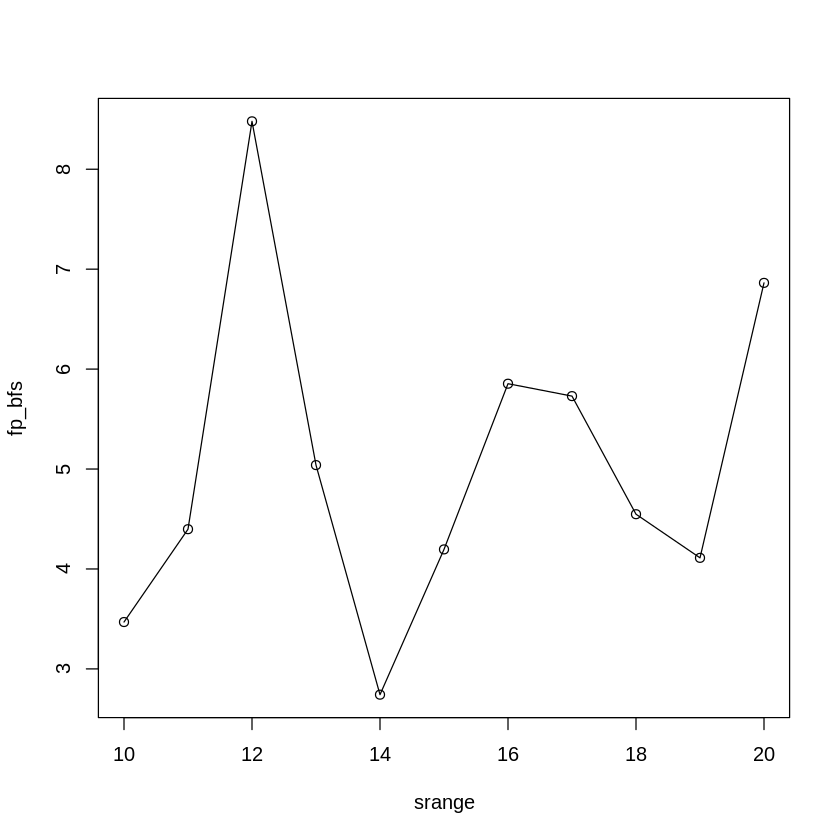

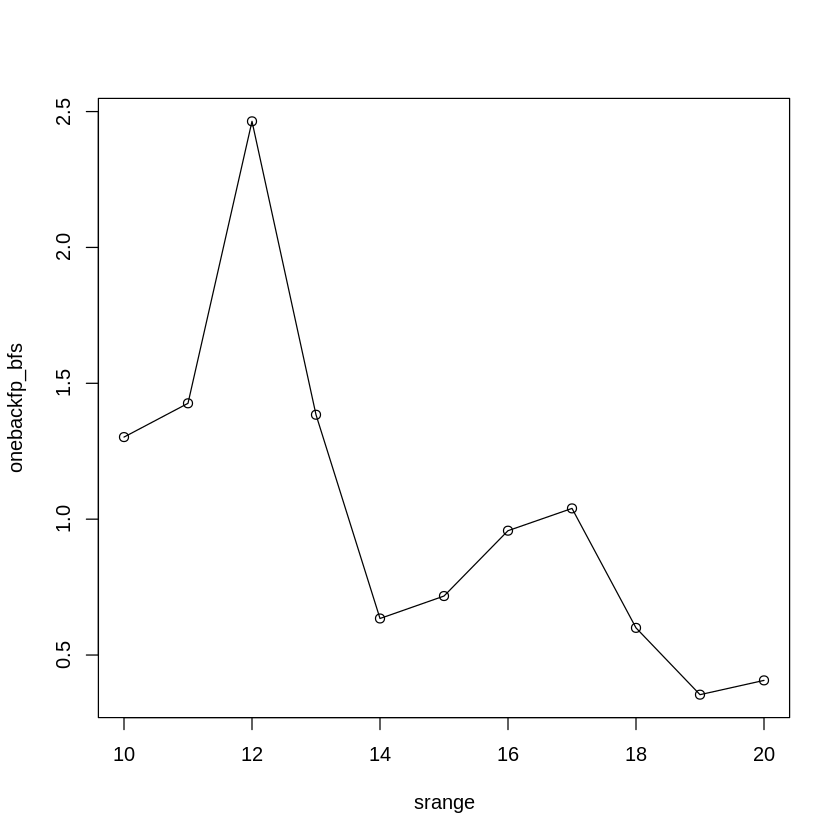

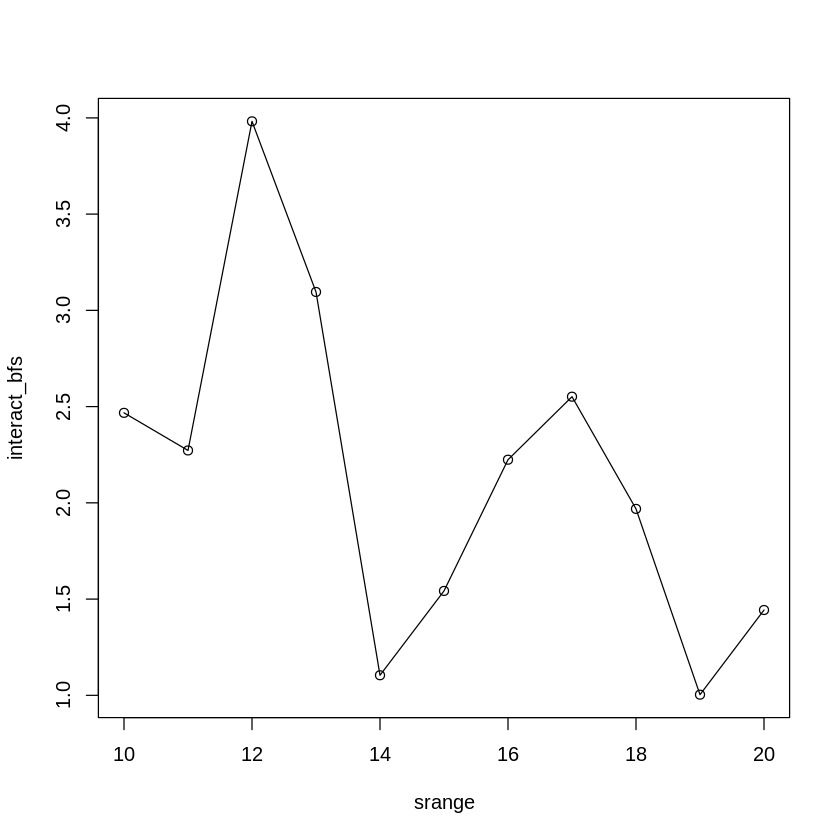

In [ ]:
external_fits <- fitted_data[fitted_data$condition=='external',]
action_fits <- fitted_data[fitted_data$condition=='action',]

srange <- 10:nrow(external_fits)

fp_bfs <- sapply(srange, function(range) {
  extractBF(ttestBF(x = external_fits$numForeperiod[1:range],
                    y = action_fits$numForeperiod[1:range],
                    paired=TRUE),
            onlybf = TRUE)
})

plot(srange, fp_bfs)
lines(srange, fp_bfs)


onebackfp_bfs <- sapply(srange, function(range) {
  extractBF(ttestBF(x = external_fits$numOneBackFP[1:range],
                    y = action_fits$numOneBackFP[1:range],
                    paired=TRUE),
            onlybf = TRUE)
})

plot(srange, onebackfp_bfs)
lines(srange, onebackfp_bfs)

interact_bfs <- sapply(srange, function(range) {
  extractBF(ttestBF(x = external_fits$`numForeperiod:numOneBackFP`[1:range],
                    y = action_fits$`numForeperiod:numOneBackFP`[1:range],
                    paired=TRUE),
            onlybf = TRUE)
})

plot(srange, interact_bfs)
lines(srange, interact_bfs)

As participants are added to the sample, there is moderate evidence for a difference in the effect of foreperiod between condition, and **some** evidence against any difference in the effect of FP n-1 between conditions. For interaction, we have a (kind of) decreasing BF, but right now it is approximately 1, so inconclusive.

# 2. Descriptive analysis

`summarise()` has grouped output by 'ID'. You can override using the `.groups`
argument.
`geom_smooth()` using formula = 'y ~ x'
`summarise()` has grouped output by 'ID', 'condition'. You can override using
the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


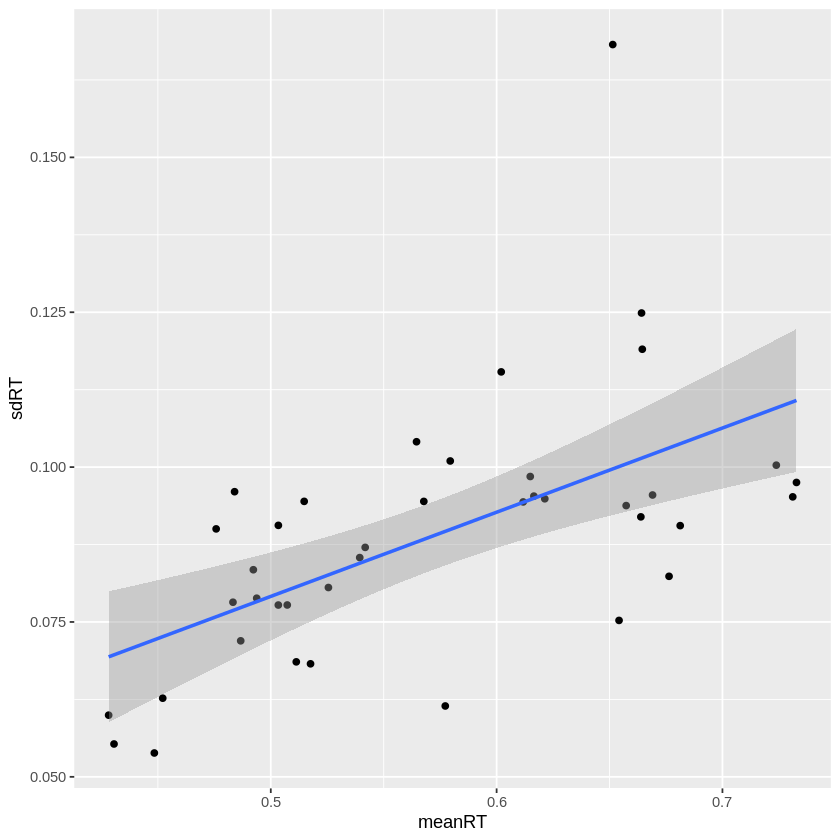

ID,condition,meanRT,sdRT
<fct>,<fct>,<dbl>,<dbl>
020,action,0.6514247,0.1682123


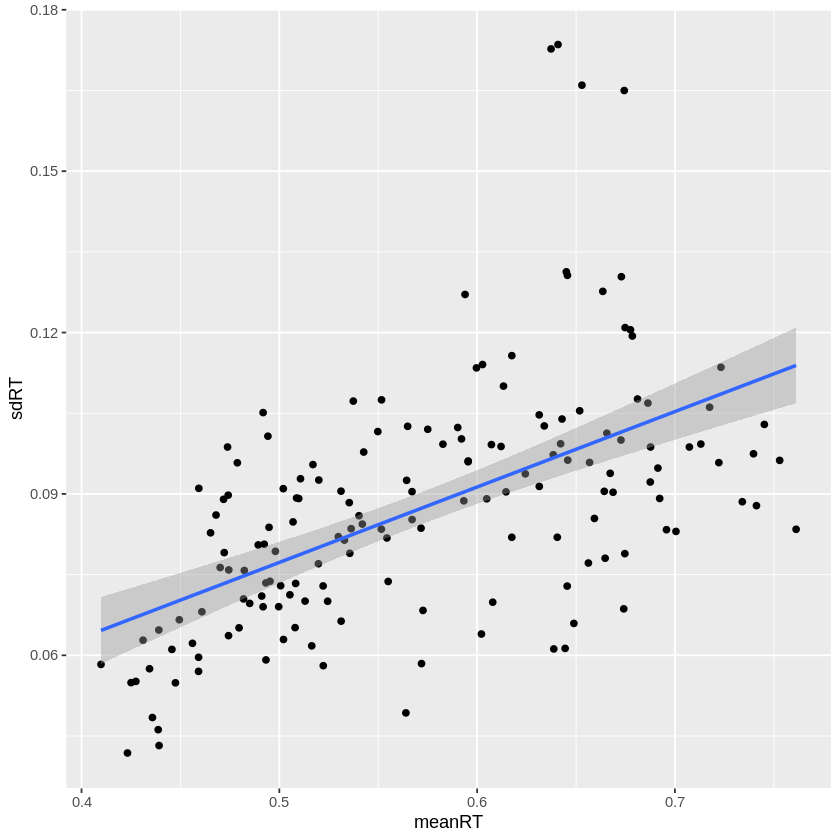

In [ ]:
# Plot histograms by participant and condition

RTstats <- data2 %>%
  group_by(ID, condition) %>%
  summarise(meanRT = mean(RT), sdRT = sd(RT)) %>%
  ungroup()
    

ggplot(data=RTstats,
aes(x=meanRT,
y=sdRT)) +
  geom_point() +
  geom_smooth(method='lm')


# Do the same by participant, condition and foreperiod
RTstats_full <- data2 %>%
  group_by(ID, condition, foreperiod) %>%
  summarise(meanRT = mean(RT), sdRT = sd(RT)) %>%
  ungroup()

ggplot(data=RTstats_full,
aes(x=meanRT,
y=sdRT)) +
  geom_point() +
  geom_smooth(method='lm')

View(RTstats[which.max(RTstats$sdRT),])

In [ ]:
cor(RTstats_full$meanRT, RTstats_full$sdRT)

[1] 0.548814

In [ ]:
options(repr.plot.width=20, repr.plot.height=16)
ggplot(data=data2,
aes(x=RT)) +
  geom_histogram() +
  facet_wrap(~ ID + condition)
options(options_defaults)

# 3. ANOVAs

In [ ]:
contrasts(summaryData$foreperiod) <- contr.treatment(4)-matrix(rep(1/4,12),ncol=3)
contrasts(summaryData$condition) <- c(-1/2, 1/2)
contrasts(summaryData$prevOri) <- c(-1/2, 1/2)
contrasts(summaryData$oneBackFP) <- contr.treatment(4)-matrix(rep(1/4,12),ncol=3)

contrasts(summaryData2$foreperiod) <- contr.treatment(4)-matrix(rep(1/4,12),ncol=3)
contrasts(summaryData2$condition) <- c(-1/2, 1/2)
contrasts(summaryData2$prevOri) <- c(-1/2, 1/2)
contrasts(summaryData2$oneBackFP) <- contr.treatment(4)-matrix(rep(1/4,12),ncol=3)

## 3.1. Foreperiod x RT by condition

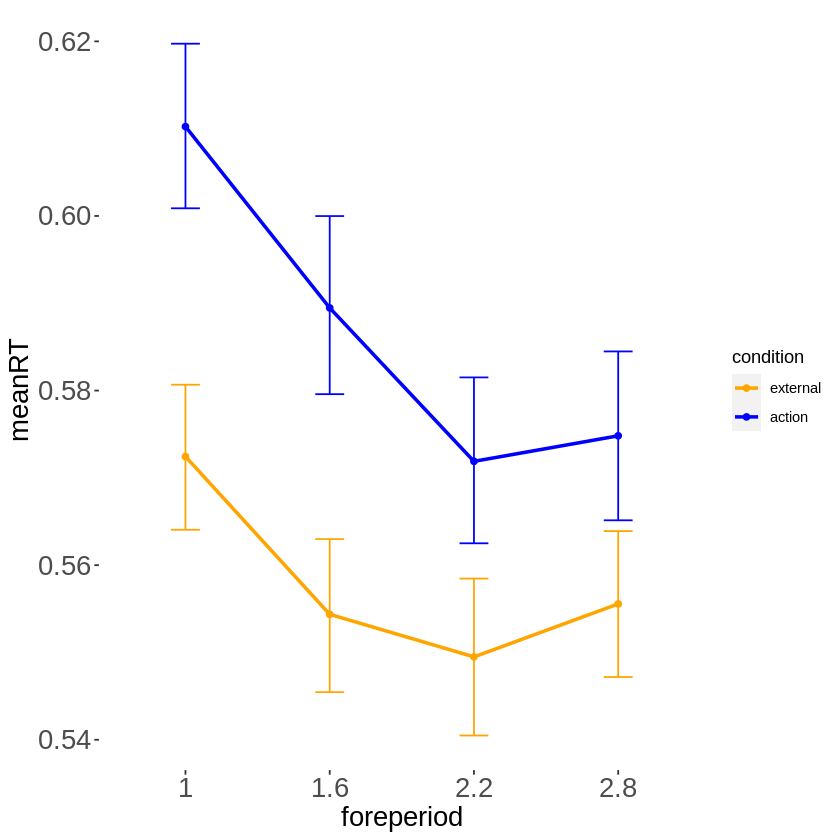

In [ ]:
# Plot RT by foreperiod and condition
ggplot(data = summaryData2,
       aes(x = foreperiod,
           y = meanRT,
           color = condition)) +
  stat_summary(fun = 'mean', geom = 'point') +
  stat_summary(fun = 'mean', geom = 'line', size = 1, aes(group = condition)) +
  stat_summary(fun.data = 'mean_cl_boot', width = 0.2, geom = 'errorbar') +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.text = element_text(size = rel(1.5)),
        axis.title = element_text(size = rel(1.5))) +
  scale_color_manual(values = c('orange','blue'))

In [ ]:
# An Anova FP x RT by condition
fpAnova <- aov_ez(id = "ID",
       dv = "meanRT",
       data = summaryData2,
       within = c("foreperiod", "condition"))

nice(fpAnova,
     correction='none')

Warning message:
“More than one observation per design cell, aggregating data using `fun_aggregate = mean`.
To turn off this warning, pass `fun_aggregate = mean` explicitly.”


Effect,df,MSE,F,ges,p.value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
foreperiod,"3, 57",0.00,26.25 ***,.018,<.001
condition,"1, 19",0.01,5.92 *,.024,.025
foreperiod:condition,"3, 57",0.00,3.20 *,.002,.030


Nothing new here: the same main effects and interactions as in the previous experiment, although the decrease in the effect of condition as FP duration increases is much less marked here.

## 3.2 Sequential effects

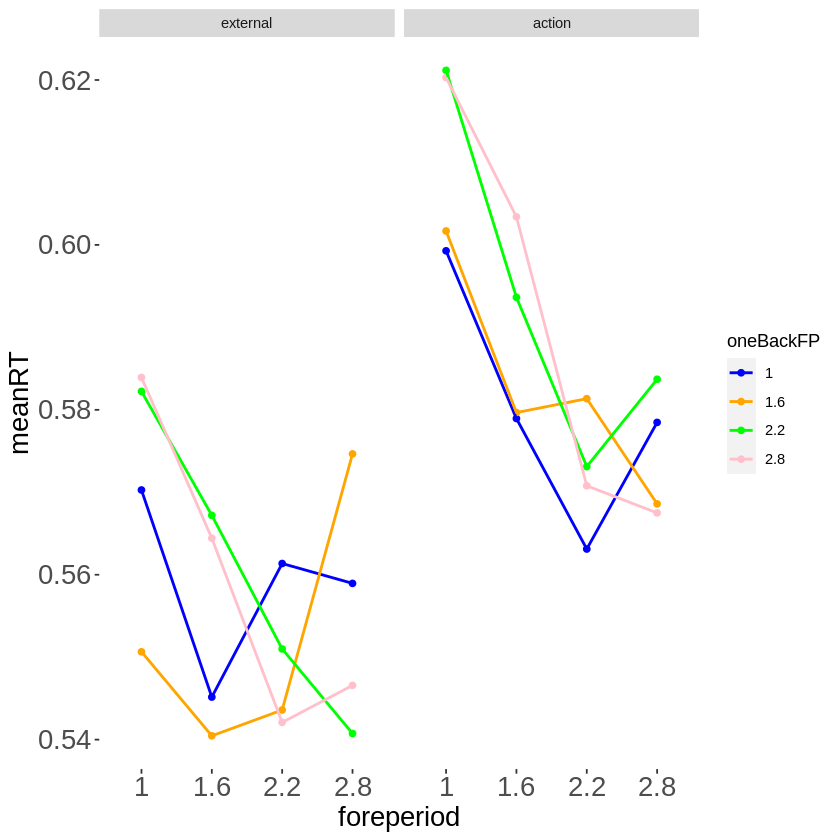

In [ ]:
# 2.2.3. Sequential effects (split by condition)
ggplot(data = summaryData2,
       aes(x = foreperiod,
           y = meanRT,
           color = oneBackFP)) +
  stat_summary(fun = "mean", geom = "point", size = 1.5) +
  stat_summary(fun = "mean", geom = "line", size = 0.8, aes(group=oneBackFP)) +
  #stat_summary(fun.data = "mean_cl_boot", size = 0.8, width = 0.2, geom = "errorbar") +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.text = element_text(size = rel(1.5)),
        axis.title = element_text(size = rel(1.5))) +
  facet_wrap(~condition) +
  scale_color_manual(values = c('blue','orange','green', 'pink'))

This is a very non-informative plot, I think. Then again, we do have few partipants and 4x4x2=32 cells among which to split the data, so we shouldn't expect much from this.

In [ ]:
# Anova including FP n-1
seqEffAnova <- aov_ez(id = "ID",
                  dv = "meanRT",
                  data = summaryData2,
                  within = c("foreperiod", "condition", "oneBackFP"))

nice(seqEffAnova,
     correction='none')

Warning message:
“More than one observation per design cell, aggregating data using `fun_aggregate = mean`.
To turn off this warning, pass `fun_aggregate = mean` explicitly.”


Effect,df,MSE,F,ges,p.value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
foreperiod,"3, 57",0.00,24.47 ***,.017,<.001
condition,"1, 19",0.02,6.56 *,.023,.019
oneBackFP,"3, 57",0.00,2.24 +,.002,.094
foreperiod:condition,"3, 57",0.00,4.11 *,.002,.010
foreperiod:oneBackFP,"9, 171",0.00,2.61 **,.004,.008
condition:oneBackFP,"3, 57",0.00,1.95,.001,.131
foreperiod:condition:oneBackFP,"9, 171",0.00,1.45,.002,.171


Not a lot to see here; the expected main effects of foreperiod and condition are present, as well as the interaction between foreperiod and FP n-1. No interesting new interactions appear (apart from the interaction between foreperiod and condition, from the previous analysis).

## 3.3. Difference between the durations of FP and FP n-1

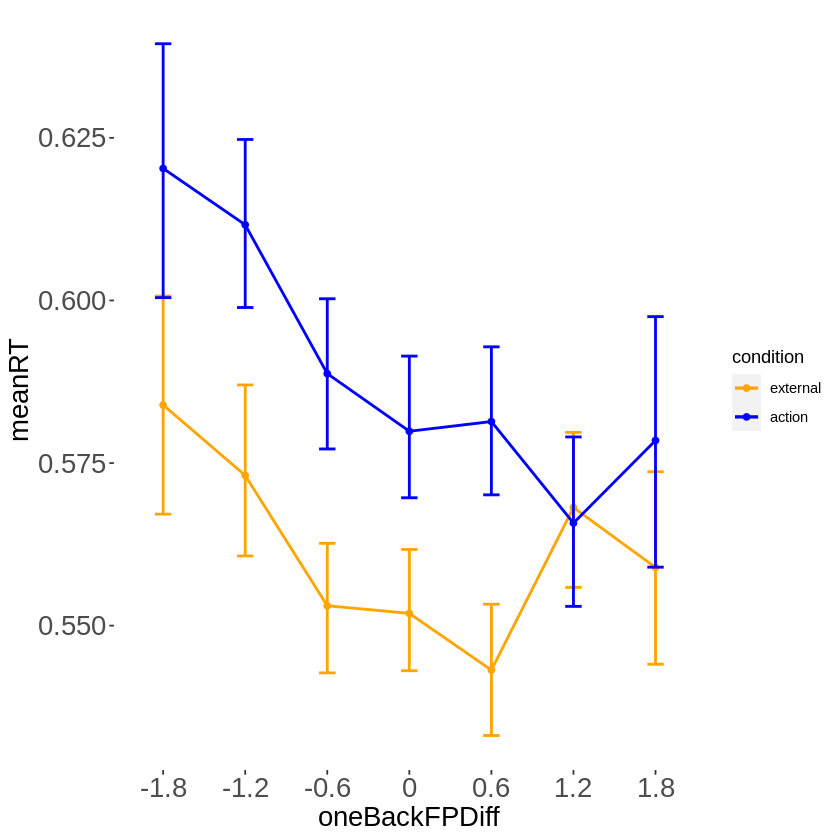

In [ ]:
ggplot(data = summaryData2,
       aes(x = oneBackFPDiff,
           y = meanRT,
           color = condition)) +
  stat_summary(fun = "mean", geom = "point", size = 1.5) +
  stat_summary(fun = "mean", geom = "line", size = 0.8, aes(group = condition)) +
  stat_summary(fun.data = "mean_cl_boot", size = 0.8, width = 0.2, geom = "errorbar") +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.text = element_text(size = rel(1.5)),
        axis.title = element_text(size = rel(1.5))) +
  scale_color_manual(values = c('orange', 'blue'))

It makes sense that RT decreases as the difference increases (meaning the current FP increases relative to the previous). The RT values for the last two values fo the difference are confusing to interpret, though.

However, we can see whether mixed models can make any meaningful contribution, since there was so much variability across participants in the previous experiments.

# 4. Linear mixed models

Before fitting the models, we create some functions to plot residuals and fits.

In [ ]:
hist_resid <- function(M,ptitle='Residuals') {
  d <- data.frame(resid=residuals(M)) 
  d  %>% ggplot(aes(x=resid)) + 
    geom_histogram(aes(y=..density..), bins=75, color='black', fill='grey') + 
    geom_density(color='darkred') + 
    ggtitle(ptitle) -> pl
  return(pl)
}

fitstats = function(M,mname='M') {
  QQ<-qqnorm(residuals(M), plot.it=FALSE)
  R2qq <- cor(QQ$x,QQ$y)^2
  dfqq = data.frame(stat='R2qq', V1=R2qq)
  r2tab <- r.squaredGLMM(M)  %>% 
    t  %>% as.data.frame  %>% rownames_to_column(var='stat')  %>% 
    rbind(.,dfqq)
  r2tab$stat = c("$R^2_m$","$R^2_c$",'$R^2_{qq}$' )
  colnames(r2tab) <- c('stat',mname)
  return(r2tab)
}

## 4.1. Assessing the need for mixed models in the data

Here, we plot the data to check whether random intercepts or slopes are distinguishable in the data, i.e., if there is anything to gain using LMM instead of ANOVAs.


Call:
lm(formula = meanRT ~ foreperiod, data = summaryData)

Residuals:
    Min      1Q  Median      3Q     Max 
-279.11  -94.28   -7.96   80.08  438.94 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     585.706      3.121 187.638  < 2e-16 ***
foreperiod1600  -20.396      4.393  -4.643 3.51e-06 ***
foreperiod2200  -31.645      4.389  -7.210 6.23e-13 ***
foreperiod2800  -27.729      4.380  -6.330 2.61e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 123.8 on 6402 degrees of freedom
Multiple R-squared:  0.009536,	Adjusted R-squared:  0.009072 
F-statistic: 20.55 on 3 and 6402 DF,  p-value: 3.028e-13


`summarise()` has grouped output by 'ID'. You can override using the `.groups`
argument.


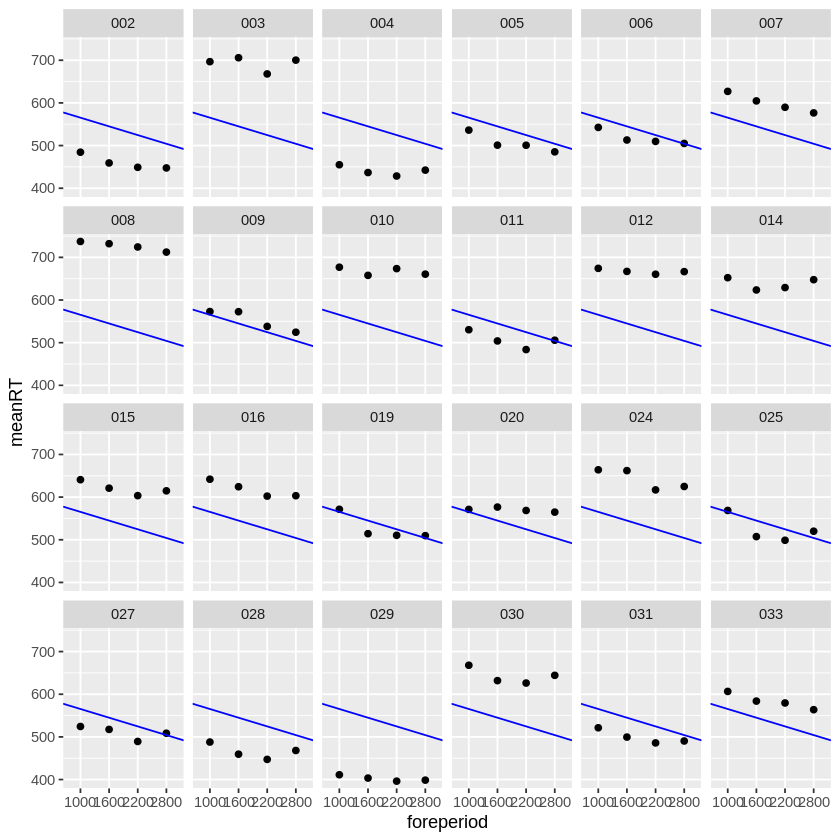

In [19]:
# Plot RT by FP by participant and model pooling data from all participants 
FPfitAll=lm(meanRT ~ foreperiod,
            data=summaryData)

fit.params=tidy(FPfitAll)

summary(FPfitAll)


ggplot(data=summaryData,
       aes(x=foreperiod,
           y=meanRT)) +
  stat_summary(fun="mean", geom="point", size=1.5)+
  geom_abline(intercept=fit.params$estimate[1],
              slope=fit.params$estimate[2],
              color="blue")+
  facet_wrap(~ ID, ncol=6)


# Plot RT by FP by participant and model using individual fits (no pooling)
dataGroupedByRT <- summaryData %>% 
  group_by(ID,foreperiod) %>% 
  summarise(meanRT=mean(meanRT)) %>%
  ungroup() %>%
  mutate(numForeperiod=as.numeric(as.character(foreperiod)))

data.no_pooling <- dataGroupedByRT %>%
  select(-foreperiod) %>%
  group_by(ID) %>%
  nest(data = c(numForeperiod, meanRT)) %>%
  mutate(fit = map(data, ~ lm(meanRT ~ numForeperiod, data = .)),
         params = map(fit, tidy)) %>%
  ungroup() %>%
  unnest(c(params)) %>%
  select(ID, term, estimate) %>%
  complete(ID, term, fill = list(estimate = 0)) %>%
  pivot_wider(names_from = term,
              values_from = estimate) %>% 
  clean_names()


data.no_pooling <- data.no_pooling %>%
  rename(ID=id,
         numForeperiod=num_foreperiod)


ggplot(data = dataGroupedByRT,
       aes(x = numForeperiod, y = meanRT)) + 
  geom_abline(data = data.no_pooling,
              aes(intercept = intercept,
                  slope = numForeperiod),
              color = "blue") +
  geom_point() +
  facet_wrap(~ID, ncol=6) + 
  scale_x_continuous(breaks = 0:4 * 2) +
  theme(strip.text = element_text(size = 12),
        axis.text.y = element_text(size = 12))

It is clear that intercepts vary widely across participants. Also, there seems to be quite some variation in slopes. Thus, it seems that mixed models are justified here.

## 4.2. Choose model

In [31]:
str(data2)

tibble [7,165 × 25] (S3: tbl_df/tbl/data.frame)
 $ ID                 : Factor w/ 24 levels "002","003","004",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Acc                : num [1:7165] 1 1 1 1 1 1 1 1 1 1 ...
 $ condition          : Factor w/ 2 levels "external","action": 1 1 1 1 1 1 1 1 1 1 ...
  ..- attr(*, "contrasts")= num [1:2, 1] -0.5 0.5
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2] "external" "action"
  .. .. ..$ : NULL
 $ block              : Factor w/ 4 levels "0","1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ orientation        : Factor w/ 2 levels "left","right": 2 1 2 1 2 2 1 1 1 1 ...
 $ foreperiod         : Factor w/ 4 levels "1000","1600",..: 1 4 2 4 2 3 1 4 1 4 ...
  ..- attr(*, "contrasts")= num [1:4, 1:3] -0.25 0.75 -0.25 -0.25 -0.25 -0.25 0.75 -0.25 -0.25 -0.25 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:4] "1000" "1600" "2200" "2800"
  .. .. ..$ : chr [1:3] "2" "3" "4"
 $ RT                 : num [1:7165] 403 406 398 502 471 ...
 $ counterbalanc

### 4.2.1. Assign contrasts

In [25]:
contrasts(data$foreperiod) <- contr.treatment(4)-matrix(rep(1/4,12),ncol=3)
contrasts(data$logFP) <- contr.treatment(4)-matrix(rep(1/4,12),ncol=3)
contrasts(data$condition) <- c(-1/2, 1/2)
contrasts(data$prevOri) <- c(-1/2, 1/2)
contrasts(data$oneBackFP) <- contr.treatment(4)-matrix(rep(1/4,12),ncol=3)

contrasts(data2$foreperiod) <- contr.treatment(4)-matrix(rep(1/4,12),ncol=3)
contrasts(data2$logFP) <- contr.treatment(4)-matrix(rep(1/4,12),ncol=3)
contrasts(data2$condition) <- c(-1/2, 1/2)
contrasts(data2$prevOri) <- c(-1/2, 1/2)
contrasts(data2$oneBackFP) <- contr.treatment(4)-matrix(rep(1/4,12),ncol=3)

### 4.2.2. Choose dependent variable 
Now, we examine if raw RT or some transformation leads to a better fit. We also assess the impact of trimming outliers (defined as mean +- 3SDs).

We are interested in the effect of foreperiod across the range of values use here (that was one of the reasons for employing 4 FP durations instead of 3 in this experiment). Also, fitting foreperiod and FP n-1 as factors makes converging very difficult. For these reasons, we insert both variables in the model as numerical variables

To choose the data transformation that leads to the optimal random effects structure, we fit models including only random intercepts and compare R2 and residuals

In [ ]:
# Fit models with RT and inverse RT without trimming
fplmm1 <- mixed(formula = RT ~ numForeperiod*condition*numOneBackFP + 
                  (1|ID),
                data = data,
                control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                progress = TRUE,
                expand_re = TRUE,
                method =  'S',
                #REML=TRUE,
                REML=FALSE,
                return = "merMod")


# Now we run the same model with inverse RT and logRT as outcomes
invfplmm1 <- mixed(formula = invRT ~ numForeperiod*condition*numOneBackFP + 
                     (1|ID),
                   data = data,
                   control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                   progress = TRUE,
                   expand_re = TRUE,
                   method =  'S',
                   #REML=TRUE,
                   REML=FALSE,
                   return = "merMod")

logfplmm1 <- mixed(formula = logRT ~ numForeperiod*condition*numOneBackFP + 
                     (1|ID),
                   data = data,
                   control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                   progress = TRUE,
                   expand_re = TRUE,
                   method =  'S',
                   #REML=TRUE,
                   REML=FALSE,
                   return = "merMod")

# Let's check that the current structure does not provide a singular fit:
isSingular(fplmm1)
isSingular(invfplmm1)
isSingular(logfplmm1)

# None of them return singular fits!

Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower orde

[1] FALSE

[1] FALSE

[1] FALSE

Warning message in par(graphical_defaults):
“graphical parameter "cin" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cra" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "csi" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cxy" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "din" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "page" cannot be set”


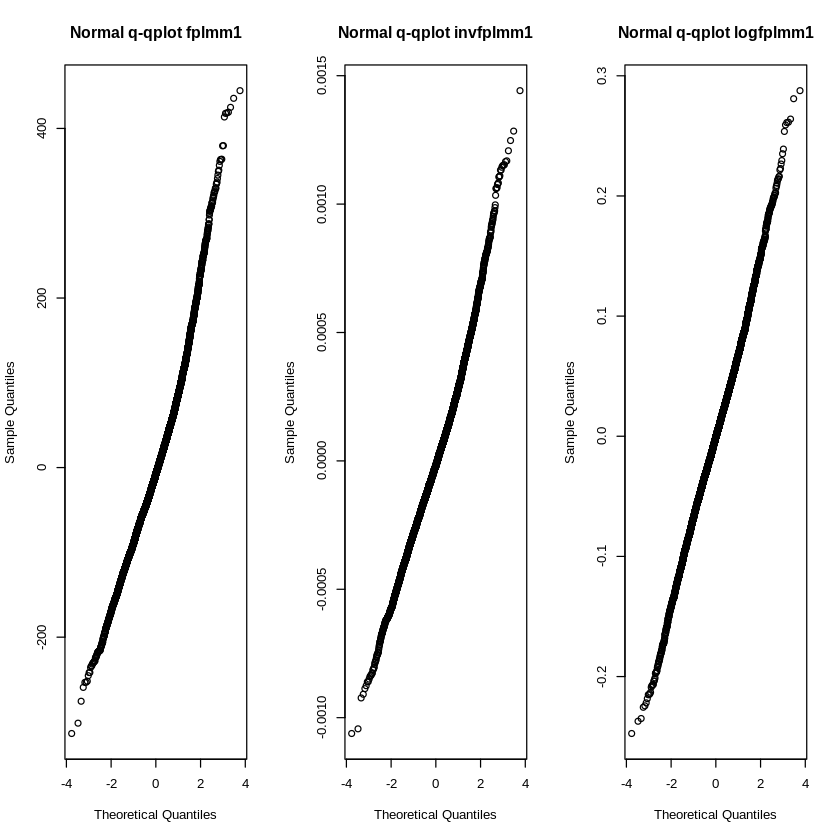

Warning message in par(graphical_defaults):
“graphical parameter "cin" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cra" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "csi" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cxy" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "din" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "page" cannot be set”


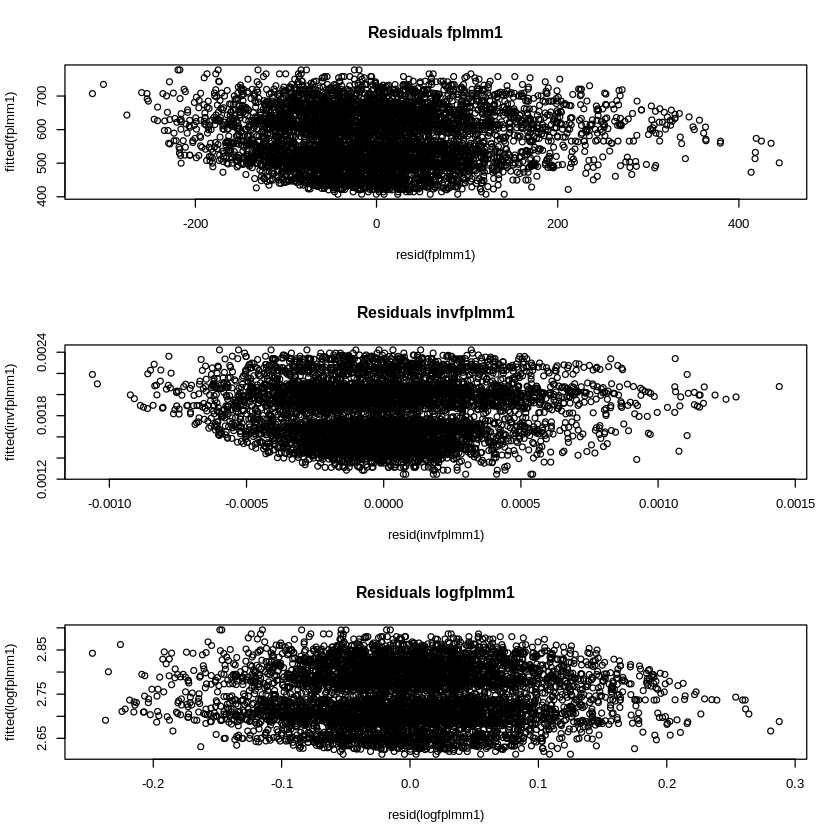

Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower orde

[1] FALSE

[1] FALSE

[1] FALSE

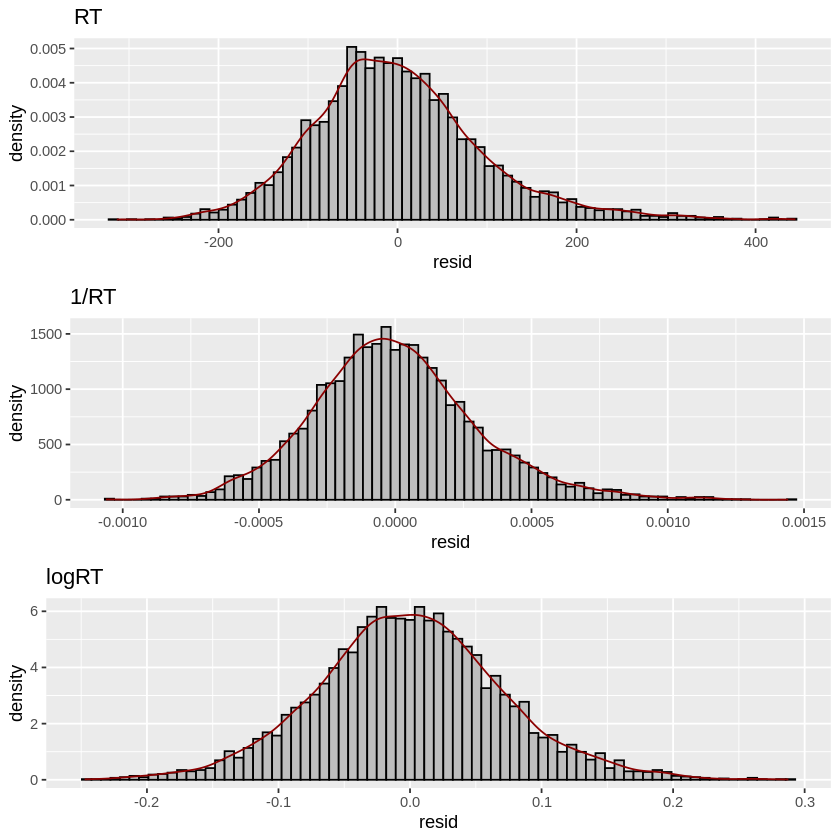

Warning message in par(graphical_defaults):
“graphical parameter "cin" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cra" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "csi" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cxy" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "din" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "page" cannot be set”


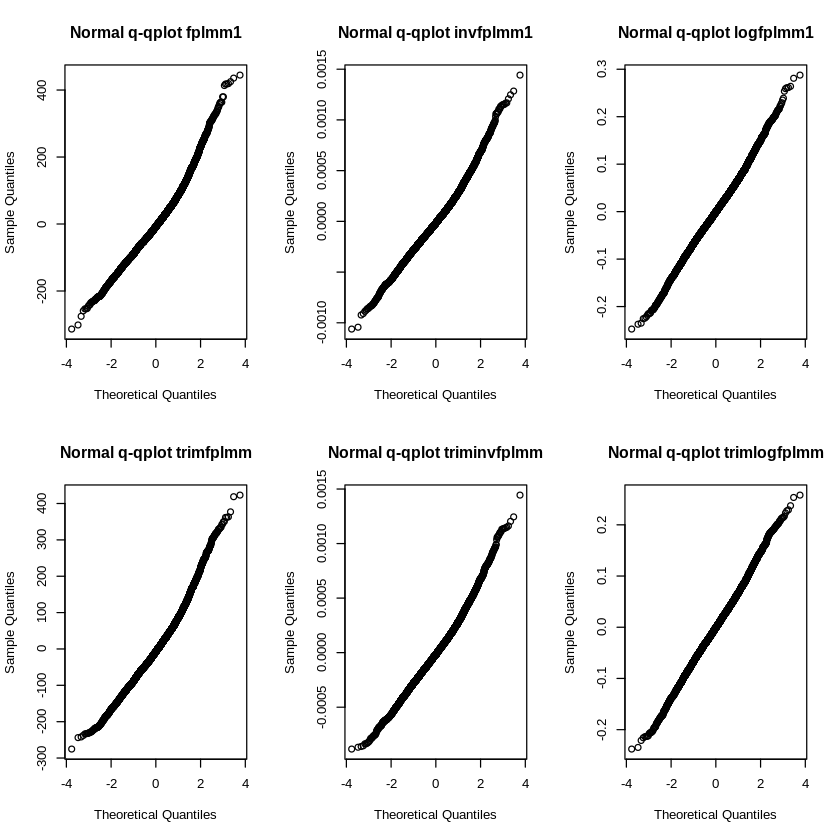

Warning message in par(graphical_defaults):
“graphical parameter "cin" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cra" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "csi" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cxy" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "din" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "page" cannot be set”


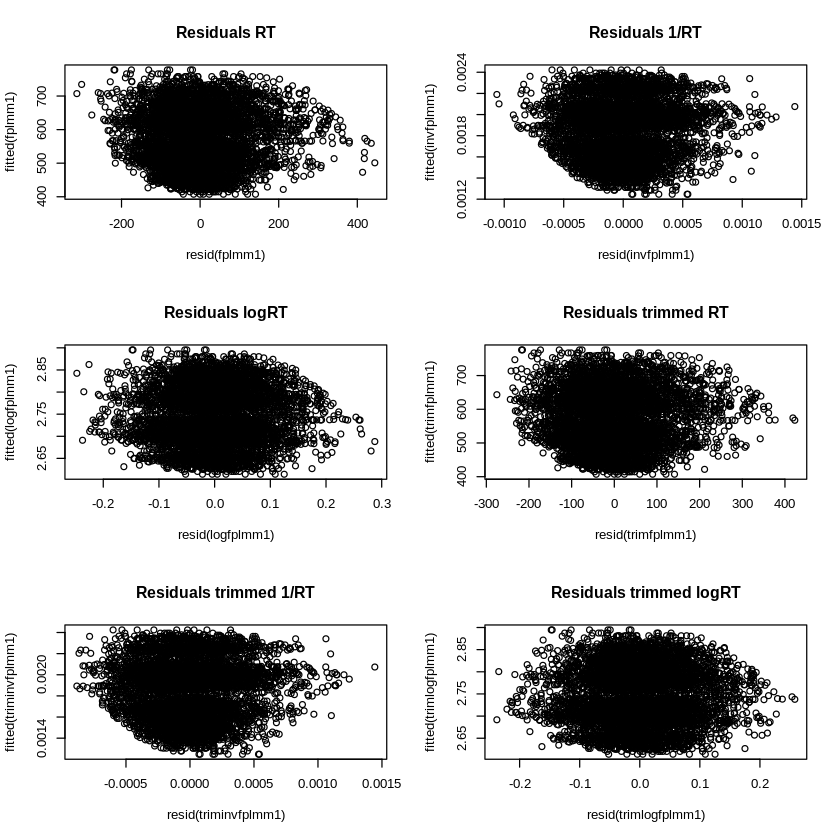

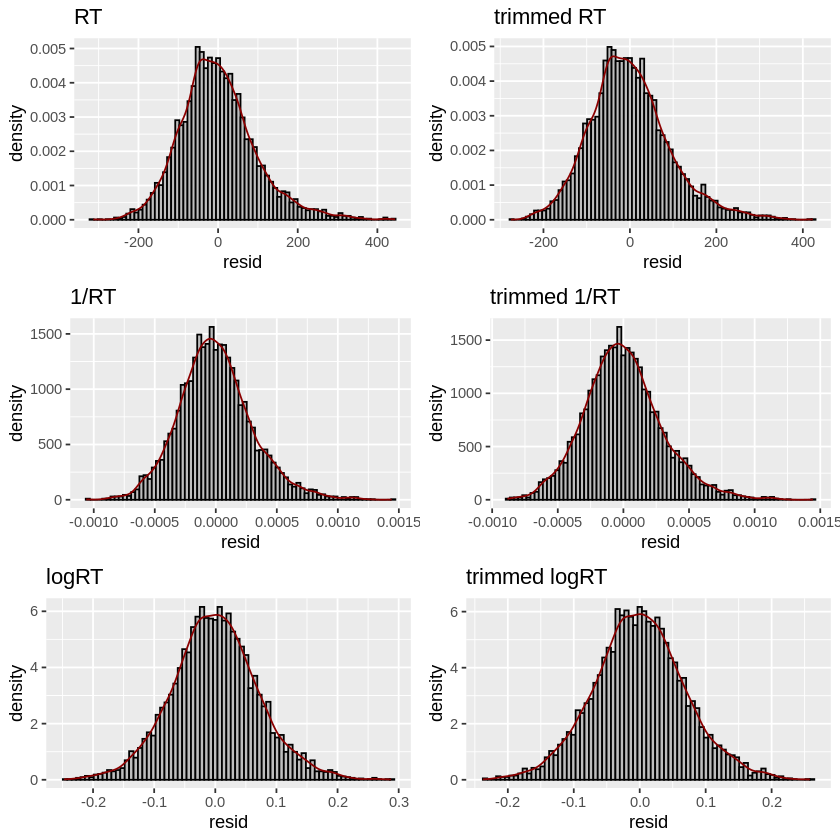

In [ ]:
# Amount of variance accounted for by the model
var <- data.frame(dataset = 'no trim',
                  'RT' = cor(fitted(fplmm1), data$RT)^2,
                  'invRT' = cor(fitted(invfplmm1), data$invRT)^2,
                  'logRT' = cor(fitted(logfplmm1), data$logRT)^2)


# Check normality of residuals
par(mfrow=c(1,3))
qqnorm(resid(fplmm1),
       main="Normal q-qplot fplmm1")
qqnorm(resid(invfplmm1),
       main="Normal q-qplot invfplmm1")
qqnorm(resid(logfplmm1),
       main="Normal q-qplot logfplmm1")

par(graphical_defaults)

# All models show departures from normality, although this is slightly less for log RT

# Plot residuals
par(mfrow=c(3,1))
plot(resid(fplmm1), fitted(fplmm1),
     main="Residuals fplmm1")
plot(resid(invfplmm1), fitted(invfplmm1),
     main="Residuals invfplmm1")
plot(resid(logfplmm1), fitted(logfplmm1),
     main="Residuals logfplmm1")

par(graphical_defaults)
# There are no clear correlations

# Residual histograms
grid.arrange(hist_resid(fplmm1, 'RT'),
             hist_resid(invfplmm1, '1/RT'),
             hist_resid(logfplmm1, 'logRT'),
             ncol=1)

# All appear to be relatively normally distributed, with a slight positive skew

# Fit models with RT and inverse RT without trimming
trimfplmm1 <- mixed(formula = RT ~ numForeperiod*condition*numOneBackFP + 
                  (1|ID),
                data = data2,
                control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                progress = TRUE,
                expand_re = TRUE,
                method =  'S',
                #REML=TRUE,
                REML=FALSE,
                return = "merMod")


# Now we run the same model with inverse RT and logRT as outcomes
triminvfplmm1 <- mixed(formula = invRT ~ numForeperiod*condition*numOneBackFP + 
                     (1|ID),
                   data = data2,
                   control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                   progress = TRUE,
                   expand_re = TRUE,
                   method =  'S',
                   #REML=TRUE,
                   REML=FALSE,
                   return = "merMod")

# Now we run the same model with inverse RT and logRT as outcomes
trimlogfplmm1 <- mixed(formula = logRT ~ numForeperiod*condition*numOneBackFP + 
                     (1|ID),
                   data = data2,
                   control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                   progress = TRUE,
                   expand_re = TRUE,
                   method =  'S',
                   #REML=TRUE,
                   REML=FALSE,
                   return = "merMod")

isSingular(trimfplmm1)
isSingular(triminvfplmm1)
isSingular(trimlogfplmm1)

# No singular fits here either

# Amount of variance accounted for by the model
var <- rbind(var,
             data.frame(dataset = 'trim',
             'RT' = cor(fitted(trimfplmm1), data2$RT)^2,
             'invRT' = cor(fitted(triminvfplmm1), data2$invRT)^2,
             'logRT'= cor(fitted(trimlogfplmm1), data2$logRT)^2))



# Again, the log model accounts for a larger amount of the variance, although this is pretty small

# check normality
par(mfrow=c(2,3))
qqnorm(resid(fplmm1),
       main="Normal q-qplot fplmm1")
qqnorm(resid(invfplmm1),
       main="Normal q-qplot invfplmm1")
qqnorm(resid(logfplmm1),
       main="Normal q-qplot logfplmm1")
qqnorm(resid(trimfplmm1),
       main="Normal q-qplot trimfplmm")
qqnorm(resid(triminvfplmm1),
       main="Normal q-qplot triminvfplmm")
qqnorm(resid(trimlogfplmm1),
       main="Normal q-qplot trimlogfplmm")
par(graphical_defaults)

# The log plots show the least deviations from normality, and trimming does seem to help a bit

# Plot residuals
par(mfrow=c(3,2))
plot(resid(fplmm1), fitted(fplmm1),
     main="Residuals RT")
plot(resid(invfplmm1), fitted(invfplmm1),
     main="Residuals 1/RT")
plot(resid(logfplmm1), fitted(logfplmm1),
     main="Residuals logRT")
plot(resid(trimfplmm1), fitted(trimfplmm1),
     main="Residuals trimmed RT")
plot(resid(triminvfplmm1), fitted(triminvfplmm1),
     main="Residuals trimmed 1/RT")
plot(resid(trimlogfplmm1), fitted(trimlogfplmm1),
     main="Residuals trimmed logRT")
par(graphical_defaults)

# LIttle difference after trimming, although outliers are rarer; logRT still appears to perform better

grid.arrange(hist_resid(fplmm1, 'RT'),
             hist_resid(invfplmm1, '1/RT'),
             hist_resid(logfplmm1, 'logRT'),
             hist_resid(trimfplmm1, 'trimmed RT'),
             hist_resid(triminvfplmm1, 'trimmed 1/RT'),
             hist_resid(trimlogfplmm1, 'trimmed logRT'),
             ncol=2,
             as.table=FALSE)

# The same pattern is apparent as in the model with no trimming

R2table <- fitstats(fplmm1, 'RT') %>%
  plyr::join(., fitstats(invfplmm1, '1/(RT)'), by='stat') %>%
  plyr::join(., fitstats(logfplmm1, 'log(RT)'), by='stat') %>%
  plyr::join(., fitstats(trimfplmm1, 'trim RT'), by='stat') %>%
  plyr::join(., fitstats(triminvfplmm1, 'trim 1/(RT)'), by='stat') %>%
  plyr::join(., fitstats(trimlogfplmm1, 'trim log(RT)'), by='stat') %>%
  kable(digits=4)

# Indeed, the model using trimmed logRT performs best according to fit. All R2qq are very low 

In [ ]:
R2table



|stat       |     RT| 1/(RT)| log(RT)| trim RT| trim 1/(RT)| trim log(RT)|
|:----------|------:|------:|-------:|-------:|-----------:|------------:|
|$R^2_m$    | 0.0245| 0.0224|  0.0240|  0.0212|      0.0199|       0.0210|
|$R^2_c$    | 0.4350| 0.4404|  0.4474|  0.4502|      0.4513|       0.4601|
|$R^2_{qq}$ | 0.9778| 0.9888|  0.9975|  0.9814|      0.9892|       0.9985|

In [ ]:
# Use z-scores for centering with no outlier trimming
fplmm3 <- mixed(formula = RTzscore ~ numForeperiod*condition*numOneBackFP + 
                  (1|ID),
                data = data,
                control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                progress = TRUE,
                expand_re = TRUE,
                method =  'S',
                REML=TRUE,
                return = "merMod")

isSingular(fplmm3)

# Amount of variance accounted for by the model
cor(fitted(fplmm3), data$RT)^2

# Very low variance explained

# check normality
qqnorm(resid(fplmm3),
       main="Normal q-qplot fplmm3")

# Far from normality

# Plot residuals
plot(fplmm3, resid(.) ~ fitted(.),
     main="Residuals fplmm3")

# Correlation between residuals and fitted values seems to dissappear

qplot(resid(fplmm3),
      main="Residuals fplmm3")

# Residuals are quite assymnetric

# Use z-scores for centering with trimming
fplmm4 <- mixed(formula = RTzscore ~ numForeperiod*condition*numOneBackFP + 
                  (1|ID),
                data = data2,
                control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                progress = TRUE,
                expand_re = TRUE,
                method =  'S',
                REML=TRUE,
                return = "merMod")

isSingular(fplmm4)

# Singular fit

# Amount of variance accounted for by the model
cor(fitted(fplmm4), data2$RT)^2

# check normality
qqnorm(resid(fplmm4),
       main="Normal q-qplot fplmm4")

# Plot residuals
plot(fplmm4, resid(.) ~ fitted(.),
     main="Residuals fplmm4")

qplot(resid(fplmm4),
      main="Residuals fplmm4")

# The models with z-scores for RT performs horribly

In sum, variance explained is higher with trimming, although this is probably not significant;

Q-q plots are better with trimming;

Residuals are less correlated with fitted values with trimming;

Residuals are more normally distributed with trimming;

The model with inverse RT performs better than the one with RT.

## 4.3. Find random effects structure

Now we find the maximal random-effects structure that **converges**. Instead of "keeping it maximal", we use buildmer to automate the process. We use the Satterthwaite method to find degrees of freedom, as fitting the model with the other reccommended method (Kenward-Roger) leads the model not to converge.

### 4.3.1. Foreperiod, condition and FP n-1 as predictors

Foreperiod, condition and FP n-1 as predictors. We employ the default order settings and do not specify in advance and component for obligatory inclusion.

In [ ]:
trimlogfplmm1 <- buildmer(logRT ~ numForeperiod * condition * numOneBackFP + 
                            (1+numForeperiod*condition*numOneBackFP|ID), 
                          data=data2,
                          buildmerControl = buildmerControl(ddf = "Satterthwaite",
                                                            calc.anova = TRUE))#,
                                                            #args=list(control = lmerControl(optimizer = c('bobyqa')))))
formula(trimlogfplmm1)

summary(trimlogfplmm1)
isSingular(trimlogfplmm1)

Determining predictor order

Fitting via lm: logRT ~ 1

Currently evaluating LRT for: numForeperiod, condition, numOneBackFP

Fitting via lm: logRT ~ 1 + numForeperiod

Fitting via lm: logRT ~ 1 + condition

Fitting via lm: logRT ~ 1 + numOneBackFP

Updating formula: logRT ~ 1 + condition

Currently evaluating LRT for: numForeperiod, numOneBackFP

Fitting via lm: logRT ~ 1 + condition + numForeperiod

Fitting via lm: logRT ~ 1 + condition + numOneBackFP

Updating formula: logRT ~ 1 + condition + numForeperiod

Currently evaluating LRT for: numForeperiod:condition, numOneBackFP

Fitting via lm: logRT ~ 1 + condition + numForeperiod +
    numForeperiod:condition

Fitting via lm: logRT ~ 1 + condition + numForeperiod + numOneBackFP

Updating formula: logRT ~ 1 + condition + numForeperiod +
    numForeperiod:condition

Currently evaluating LRT for: numOneBackFP

Fitting via lm: logRT ~ 1 + condition + numForeperiod +
    condition:numForeperiod + numOneBackFP

Updating formula: logRT ~ 1 +

   grouping                                 term
1      <NA>                                    1
3      <NA>                            condition
2      <NA>                        numForeperiod
4      <NA>              numForeperiod:condition
5      <NA>                         numOneBackFP
6      <NA>           numForeperiod:numOneBackFP
7      <NA>               condition:numOneBackFP
8      <NA> numForeperiod:condition:numOneBackFP
9        ID                                    1
11       ID                            condition
                                        block        score Iteration
1                                     NA NA 1           NA         1
3                             NA NA condition  -34.0308897         1
2                         NA NA numForeperiod  -23.0735520         1
4               NA NA numForeperiod:condition   -5.3633424         1
5                          NA NA numOneBackFP   -2.8053474         1
6            NA NA numForeperiod:numOneBackFP  

Updating formula: logRT ~ 1 + condition + numForeperiod +
    condition:numForeperiod + numOneBackFP + numForeperiod:numOneBackFP
    + condition:numOneBackFP + (1 + condition | ID)

Fitting ML and REML reference models

Fitting via lmer, with REML: logRT ~ 1 + condition + numForeperiod +
    condition:numForeperiod + numOneBackFP + numForeperiod:numOneBackFP
    + condition:numOneBackFP + (1 + condition | ID)

Fitting via lmer, with ML: logRT ~ 1 + condition + numForeperiod +
    condition:numForeperiod + numOneBackFP + numForeperiod:numOneBackFP
    + condition:numOneBackFP + (1 + condition | ID)

Testing terms

Fitting via lmer, with ML: logRT ~ 1 + condition + numForeperiod +
    numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP
    + (1 + condition | ID)

Fitting via lmer, with ML: logRT ~ 1 + condition + numForeperiod +
    condition:numForeperiod + numOneBackFP + condition:numOneBackFP +
    (1 + condition | ID)

Fitting via lmer, with ML: logRT ~ 1 + condition 

   grouping                       term                            block
1      <NA>                          1                          NA NA 1
3      <NA>                  condition                  NA NA condition
2      <NA>              numForeperiod              NA NA numForeperiod
4      <NA>    numForeperiod:condition    NA NA numForeperiod:condition
5      <NA>               numOneBackFP               NA NA numOneBackFP
6      <NA> numForeperiod:numOneBackFP NA NA numForeperiod:numOneBackFP
7      <NA>     condition:numOneBackFP     NA NA condition:numOneBackFP
9        ID                          1                          NA ID 1
11       ID                  condition                  NA ID condition
         score Iteration          LRT
1           NA         2           NA
3   -34.030890         2           NA
2   -23.073552         2           NA
4    -5.363342         2 3.136601e-04
5    -2.805347         2           NA
6    -9.425523         2 1.136544e-06
7    -1.745603

All terms are significant

Finalizing by converting the model to lmerTest



logRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
    numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
    (1 + condition | ID)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: logRT ~ 1 + condition + numForeperiod + condition:numForeperiod +  
    numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP +  
    (1 + condition | ID)
   Data: data2

REML criterion at convergence: -14871.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6094 -0.6301 -0.0190  0.6383  4.0705 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept) 0.004175 0.06461       
          condition1  0.001325 0.03641  -0.02
 Residual             0.004558 0.06752       
Number of obs: 5950, groups:  ID, 20

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 2.727e+00  1.653e-02  3.227e+01 165.032  < 2e-16
condition1                  2.711e-02  1.097e-02  5.708e+01   2.471 0.016471
numForeperiod               6.595e-06  3.950e-06  5.906e+03   1.670 0.095071
numOneBackFP     

[1] FALSE

All effects are significant but the effect of foreperiod. There are two caveats, though:

1.   We modelled foreperiod linearly, which prob does not capture the 'u' pattern;
2.   The interaction with condition is significant, so the interpretation of the main effect of condition is less important.

More importantly, the interaction between condition and FP n-1 is significant. But this is not straightforward to interpret, since the data looks so randomly distributed when pooled. To double-check, we can use the difference between foreperiods (current and previous).



Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
NOTE: numForeperiod is not a high-order term in the model




 numForeperiod effect
numForeperiod
    1000     1400     1900     2400     2800 
2.751849 2.747160 2.741300 2.735439 2.730751 

 Lower 95 Percent Confidence Limits
numForeperiod
    1000     1400     1900     2400     2800 
2.724553 2.719919 2.714083 2.708199 2.703458 

 Upper 95 Percent Confidence Limits
numForeperiod
    1000     1400     1900     2400     2800 
2.779145 2.774402 2.768517 2.762680 2.758044 

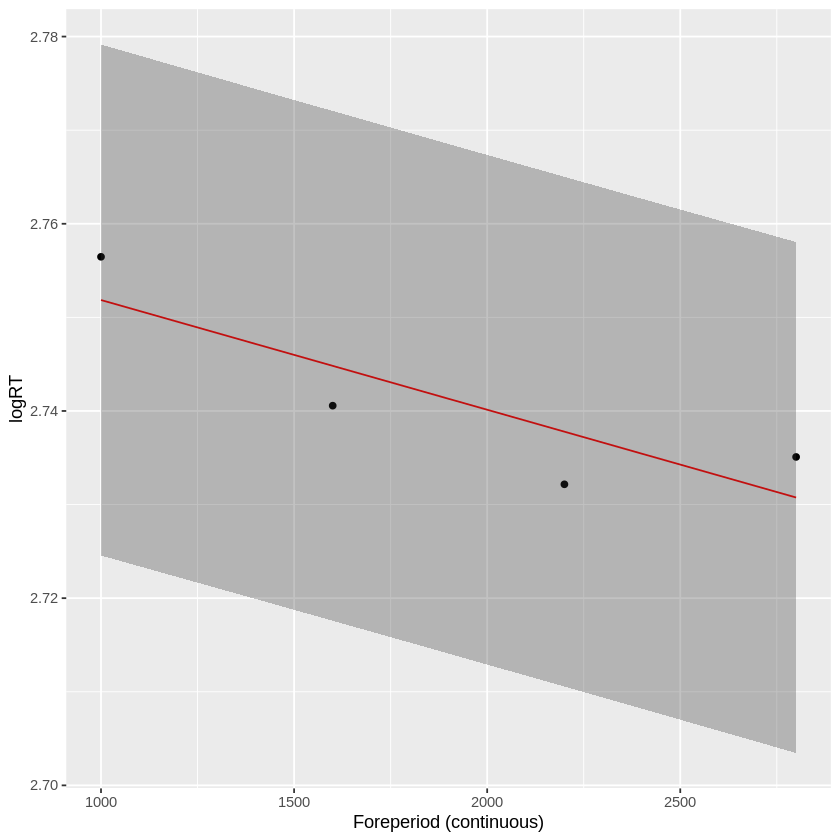

In [27]:
# Visualize effects
trimlogfplmm1 <- mixed(logRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                         numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                         (1 + condition | ID),
                       data=data2,
                       control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                       progress = TRUE,
                       expand_re = TRUE,
                       method =  'KR',
                       REML=TRUE,
                       return = "merMod",
                       check_contrasts = FALSE)

fp_effect <- effect(term='numForeperiod', mod=trimlogfplmm1)
summary(fp_effect)

fp_effect_df <- as.data.frame(fp_effect)

ggplot() +
  stat_summary(fun='mean', geom='point', data=data2, aes(x=numForeperiod, y=logRT)) +
  geom_line(data=fp_effect_df, aes(x=numForeperiod, y=fit), color='red') +
  geom_ribbon(data=fp_effect_df, aes(x=numForeperiod, ymin=lower, ymax=upper), alpha=0.3) +
  labs(x='Foreperiod (continuous)', y='logRT')

In [34]:
h_trimlogfplmm1 <- mixed(logRT ~ 1 + numForeperiod + (1 | ID),
                       data=data2,
                       control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                       progress = TRUE,
                       expand_re = TRUE,
                       method = 'KR',
                       REML=TRUE,
                       return = "merMod",
                       check_contrasts = FALSE)

                       h_trimlogfplmm2 <- mixed(logRT ~ 1 + numForeperiod + numOneBackFP + numForeperiod:numOneBackFP + (1 | ID),
                       data=data2,
                       control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                       progress = TRUE,
                       expand_re = TRUE,
                       method =  'KR',
                       REML=TRUE,
                       return = "merMod",
                       check_contrasts = FALSE)

h_trimlogfplmm3 <- mixed(logRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                         numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + (1 | ID),
                       data=data2,
                       control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                       progress = TRUE,
                       expand_re = TRUE,
                       method =  'KR',
                       REML=TRUE,
                       return = "merMod",
                       check_contrasts = FALSE)

h_trimlogfplmm4 <- mixed(logRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                         numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                         (1 + condition | ID),
                       data=data2,
                       control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                       progress = TRUE,
                       expand_re = TRUE,
                       method =  'KR',
                       REML=TRUE,
                       return = "merMod",
                       check_contrasts = FALSE)

anova(h_trimlogfplmm1, h_trimlogfplmm2, h_trimlogfplmm3, h_trimlogfplmm4)

Numerical variables NOT centered on 0: numForeperiod
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message:
“Some predictor variables

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
h_trimlogfplmm1,4,-17887.29,-17859.78,8947.643,-17895.29,NA,NA,NA
h_trimlogfplmm2,6,-17910.21,-17868.94,8961.103,-17922.21,26.92001,2,1.426903e-06
h_trimlogfplmm3,9,-18027.99,-17966.09,9022.993,-18045.99,123.78155,3,1.182806e-26
h_trimlogfplmm4,11,-18392.10,-18316.45,9207.050,-18414.10,368.11377,2,1.161746e-80


Next, we compare the dependent variables using the random effects structure obtained in the previous step.

Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower orde

dataset,RT,invRT,logRT
<chr>,<dbl>,<dbl>,<dbl>
no trim,0.4703005,0.4747760,0.4821149
trim,0.4864995,0.4864334,0.4957074


Warning message in par(graphical_defaults):
“graphical parameter "cin" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cra" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "csi" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cxy" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "din" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "page" cannot be set”


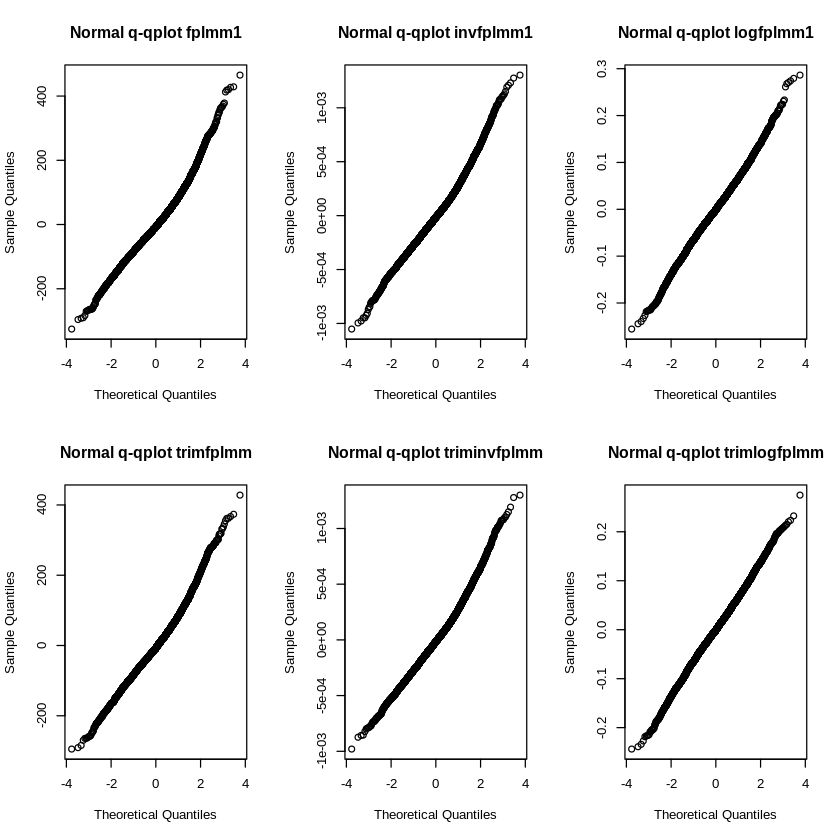

Warning message in par(graphical_defaults):
“graphical parameter "cin" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cra" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "csi" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "cxy" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "din" cannot be set”
Warning message in par(graphical_defaults):
“graphical parameter "page" cannot be set”
Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


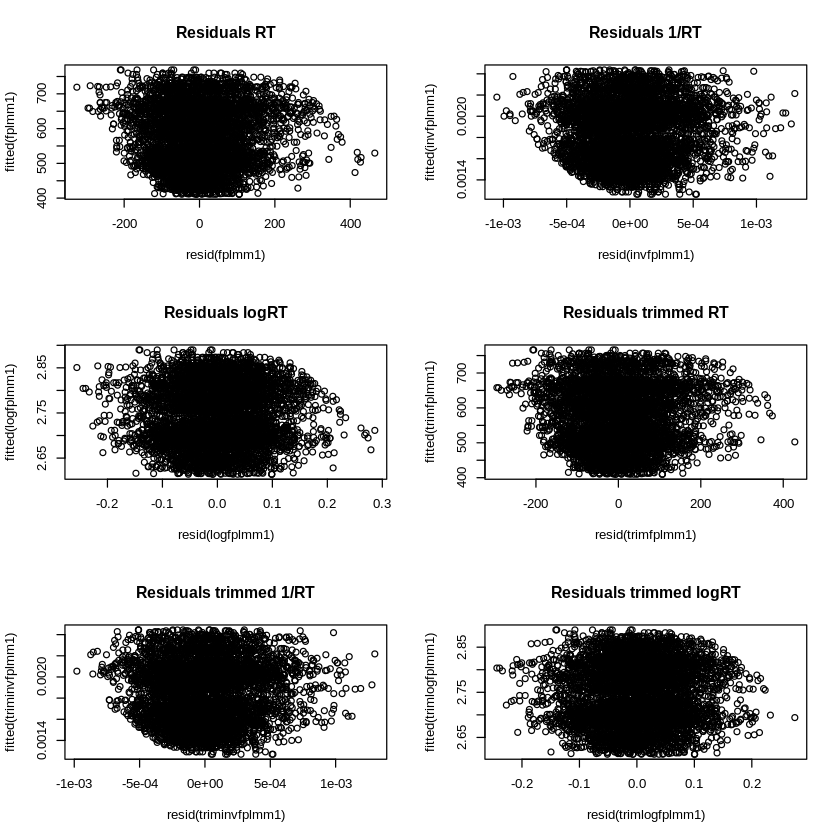

Warning message:
“'r.squaredGLMM' now calculates a revised statistic. See the help page.”


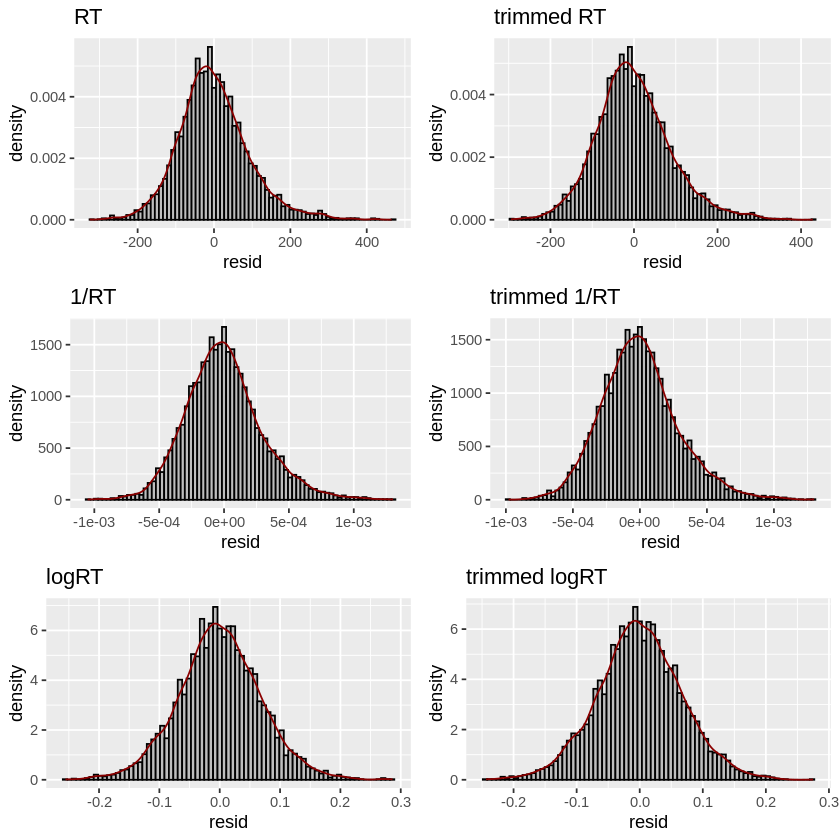

In [ ]:
# Compare dependent variables using random-effects structure
fplmm1 <- mixed(formula = RT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                  numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                  (1 + condition | ID),
                data = data,
                control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                progress = TRUE,
                expand_re = TRUE,
                method =  'KR',
                REML=TRUE,
                return = "merMod")


invfplmm1 <- mixed(formula = invRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                     numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                     (1 + condition | ID),
                   data = data,
                   control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                   progress = TRUE,
                   expand_re = TRUE,
                   method =  'KR',
                   REML=TRUE,
                   return = "merMod")

logfplmm1 <- mixed(formula = logRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                     numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                     (1 + condition | ID),
                   data = data,
                   control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                   progress = TRUE,
                   expand_re = TRUE,
                   method =  'KR',
                   REML=TRUE,
                   return = "merMod")

trimfplmm1 <- mixed(formula = RT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                      numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                      (1 + condition | ID),
                data = data2,
                control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                progress = TRUE,
                expand_re = TRUE,
                method =  'KR',
                REML=TRUE,
                return = "merMod")


triminvfplmm1 <- mixed(formula = invRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                         numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                         (1 + condition | ID),
                   data = data2,
                   control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                   progress = TRUE,
                   expand_re = TRUE,
                   method =  'KR',
                   REML=TRUE,
                   return = "merMod")

trimlogfplmm1 <- mixed(formula = logRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                         numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                         (1 + condition | ID),
                   data = data2,
                   control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                   progress = TRUE,
                   expand_re = TRUE,
                   method =  'KR',
                   REML=TRUE,
                   return = "merMod")

# Compare model R2 and residuals
# Amount of variance accounted for by the model
var <- data.frame(dataset = 'no trim',
                  'RT' = cor(fitted(fplmm1), data$RT)^2,
                  'invRT' = cor(fitted(invfplmm1), data$invRT)^2,
                  'logRT' = cor(fitted(logfplmm1), data$logRT)^2)

var <- rbind(var,
             data.frame(dataset = 'trim',
                        'RT' = cor(fitted(trimfplmm1), data2$RT)^2,
                        'invRT' = cor(fitted(triminvfplmm1), data2$invRT)^2,
                        'logRT'= cor(fitted(trimlogfplmm1), data2$logRT)^2))

var
# Again, the log model accounts (barely) for a larger amount of the variance

# check normality
par(mfrow=c(2,3))
qqnorm(resid(fplmm1),
       main="Normal q-qplot fplmm1")
qqnorm(resid(invfplmm1),
       main="Normal q-qplot invfplmm1")
qqnorm(resid(logfplmm1),
       main="Normal q-qplot logfplmm1")
qqnorm(resid(trimfplmm1),
       main="Normal q-qplot trimfplmm")
qqnorm(resid(triminvfplmm1),
       main="Normal q-qplot triminvfplmm")
qqnorm(resid(trimlogfplmm1),
       main="Normal q-qplot trimlogfplmm")
par(graphical_defaults)

# The log plots show the least deviations from normality, and trimming does seem to help a bit

# Plot residuals
par(mfrow=c(3,2))
plot(resid(fplmm1), fitted(fplmm1),
     main="Residuals RT")
plot(resid(invfplmm1), fitted(invfplmm1),
     main="Residuals 1/RT")
plot(resid(logfplmm1), fitted(logfplmm1),
     main="Residuals logRT")
plot(resid(trimfplmm1), fitted(trimfplmm1),
     main="Residuals trimmed RT")
plot(resid(triminvfplmm1), fitted(triminvfplmm1),
     main="Residuals trimmed 1/RT")
plot(resid(trimlogfplmm1), fitted(trimlogfplmm1),
     main="Residuals trimmed logRT")
par(graphical_defaults)

grid.arrange(hist_resid(fplmm1, 'RT'),
             hist_resid(invfplmm1, '1/RT'),
             hist_resid(logfplmm1, 'logRT'),
             hist_resid(trimfplmm1, 'trimmed RT'),
             hist_resid(triminvfplmm1, 'trimmed 1/RT'),
             hist_resid(trimlogfplmm1, 'trimmed logRT'),
             ncol=2,
             as.table=FALSE)


R2table <- fitstats(fplmm1, 'RT') %>%
  plyr::join(., fitstats(invfplmm1, '1/(RT)'), by='stat') %>%
  plyr::join(., fitstats(logfplmm1, 'log(RT)'), by='stat') %>%
  plyr::join(., fitstats(trimfplmm1, 'trim RT'), by='stat') %>%
  plyr::join(., fitstats(triminvfplmm1, 'trim 1/(RT)'), by='stat') %>%
  plyr::join(., fitstats(trimlogfplmm1, 'trim log(RT)'), by='stat') %>%
  kable(digits=4)

This corroborates the comparisons using intercept-only models: By most measures, logRT with trimming still yields the best fit.

## 4.4. Choose distribution

Now we compare the fits using a gaussian and using an inverse gaussian. We employ identity links with log-transformed RTs (instead of a log link) because this seems to help the model converge. Although an ex-gaussian has been proposed as an appropriate distribution for RTs in foreperiod experiments, this is not available for lmer/glmer models.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


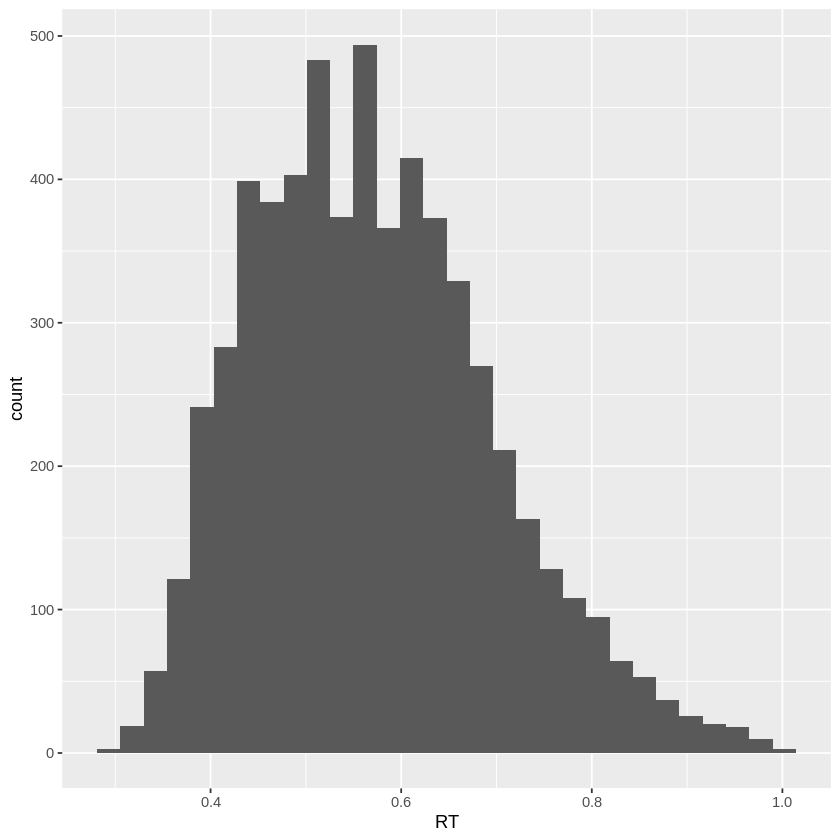

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


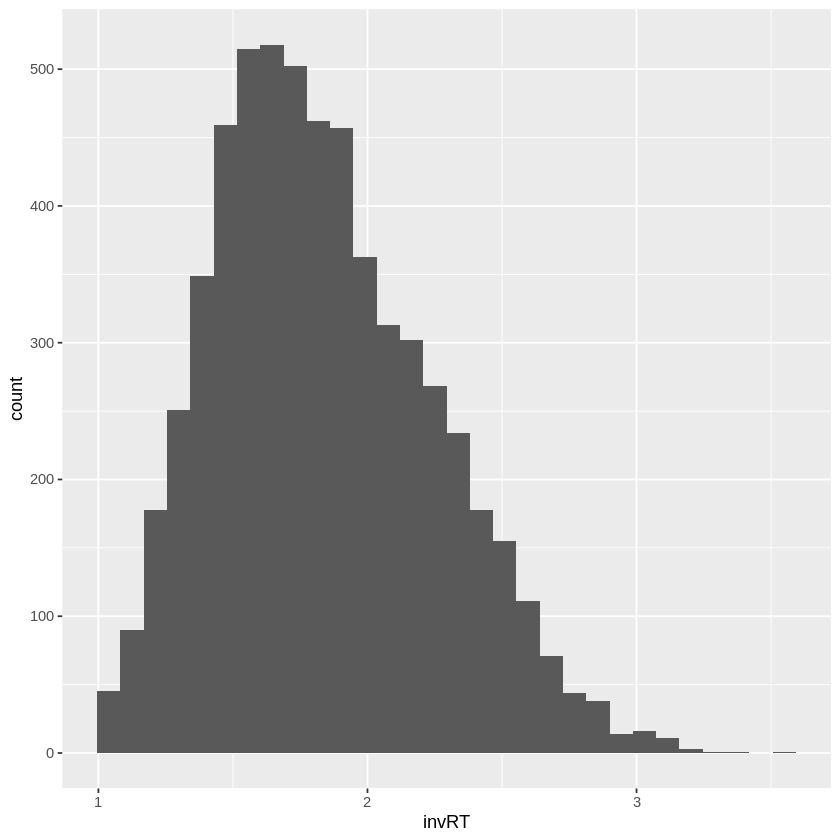

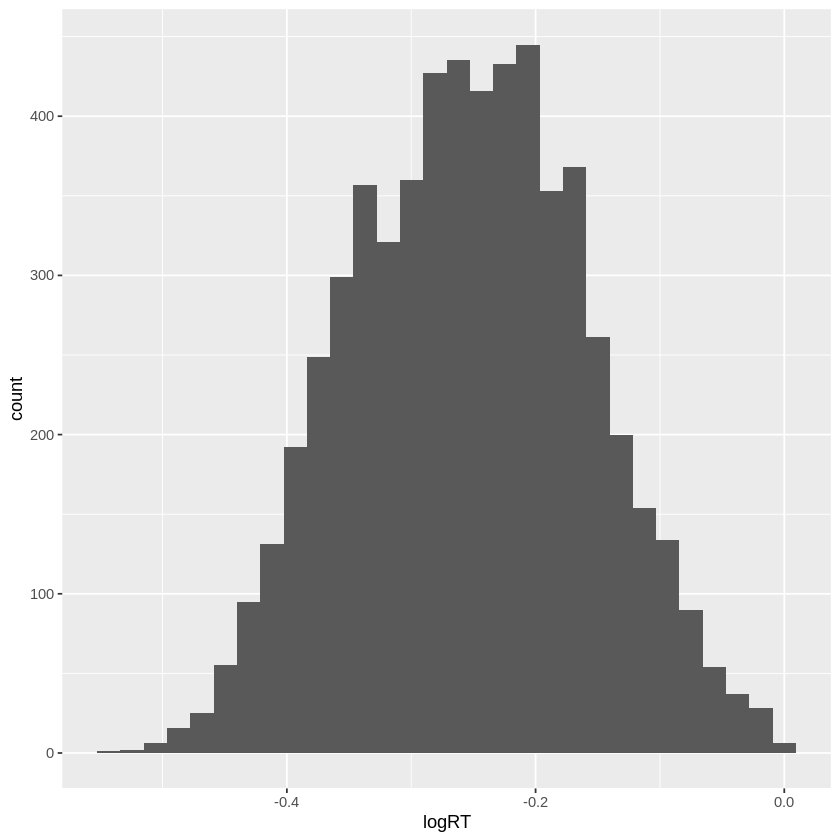

In [ ]:
# Visualize distributions for each variable
RTHistograms <- ggplot(data=data2,
                          aes(x=RT))+
  geom_histogram()
RTHistograms

invRTHistograms <- ggplot(data=data2,
                             aes(x=invRT)) +
  geom_histogram()
invRTHistograms

logRTHistograms <- ggplot(data=data2,
                             aes(x=logRT)) +
  geom_histogram()
logRTHistograms

For the first two models, there is a noticeable rightward skew. For logRT, however, the data look gaussian. Also, we the previous section, we already saw that the distribution of residuals for the logRT model approximates a gaussian quite well. In any case, it is worth it to test a different distribution.

In [ ]:
# Try models
trimlogfpgauss <- mixed(formula = logRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                       numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                       (1 + condition | ID),
                       data = data2,
                       #family=gaussian(link = "identity"),
                       control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                       progress = TRUE,
                       expand_re = TRUE,
                       method =  'KR',
                       return = "merMod")

summary(trimlogfpgauss)

trimlogfpinvgauss <- mixed(formula = logRT ~ 1 + condition + numForeperiod + condition:numForeperiod + 
                             numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP + 
                             (1 + condition | ID),
                     data = data2,
                     family=inverse.gaussian(link = "identity"),
                     control = lmerControl(optimizer = c("nloptwrap"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                     progress = TRUE,
                     expand_re = TRUE,
                     method =  'KR',
                     return = "merMod")

summary(trimlogfpinvgauss)

Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: logRT ~ 1 + condition + numForeperiod + condition:numForeperiod +  
    numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP +  
    (1 + re1.condition1 | ID)
   Data: data
Control: lmerControl(optimizer = c("bobyqa"), optCtrl = list(maxfun = 2e+05),  
    calc.derivs = FALSE)

REML criterion at convergence: -14867.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6094 -0.6301 -0.0190  0.6383  4.0705 

Random effects:
 Groups   Name           Variance  Std.Dev. Corr
 ID       (Intercept)    0.0041748 0.06461      
          re1.condition1 0.0003314 0.01820  0.02
 Residual                0.0045584 0.06752      
Number of obs: 5950, groups:  ID, 20

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 2.727e+00  1.653e-02  3.227e+01 165.031  < 2e-16
condition1                 -1.355e-02  5.485e-03  

Contrasts set to contr.sum for the following variables: condition, ID

Numerical variables NOT centered on 0: numForeperiod, numOneBackFP
If in interactions, interpretation of lower order (e.g., main) effects difficult.

Warning message in glmer(formula = logRT ~ 1 + condition + numForeperiod + condition:numForeperiod + :
“please use glmerControl() instead of lmerControl()”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: inverse.gaussian  ( identity )
Formula: logRT ~ 1 + condition + numForeperiod + condition:numForeperiod +  
    numOneBackFP + numForeperiod:numOneBackFP + condition:numOneBackFP +  
    (1 + re1.condition1 | ID)
   Data: data
Control: 
lmerControl(optimizer = c("nloptwrap"), optCtrl = list(maxfun = 2e+05),  
    calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
-15076.6 -15003.0   7549.3 -15098.6     5939 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3664 -0.6130 -0.0091  0.6309  4.0199 

Random effects:
 Groups   Name           Variance  Std.Dev. Corr
 ID       (Intercept)    3.530e-04 0.018788     
          re1.condition1 8.916e-05 0.009443 0.01
 Residual                2.297e-04 0.015156     
Number of obs: 5950, groups:  ID, 20

Fixed effects:
                             Estimate Std. Error t value Pr(>|z|)    
(Intercept)                 2.

In both cases, the effect of foreperiod shrank. Also, and of interest to use, the interaction between condition and FPn-1 is significant.

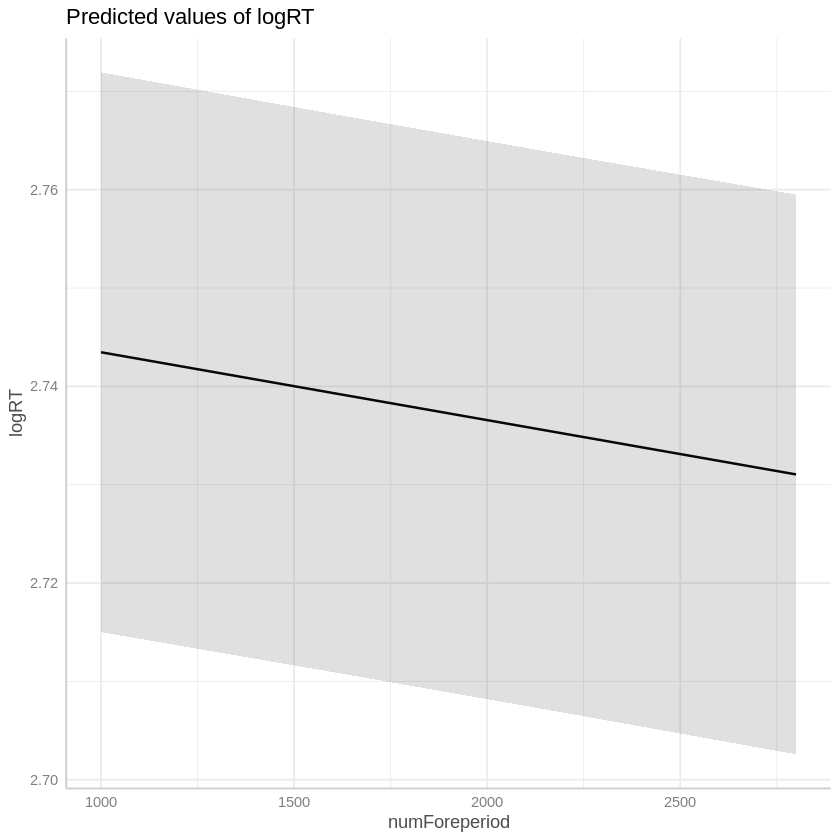

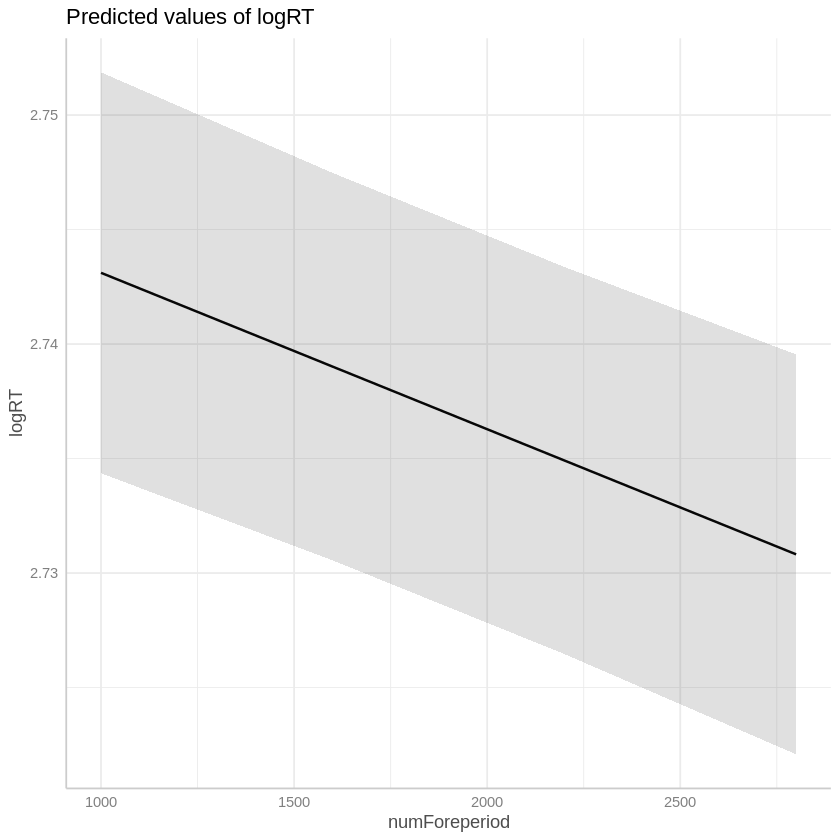

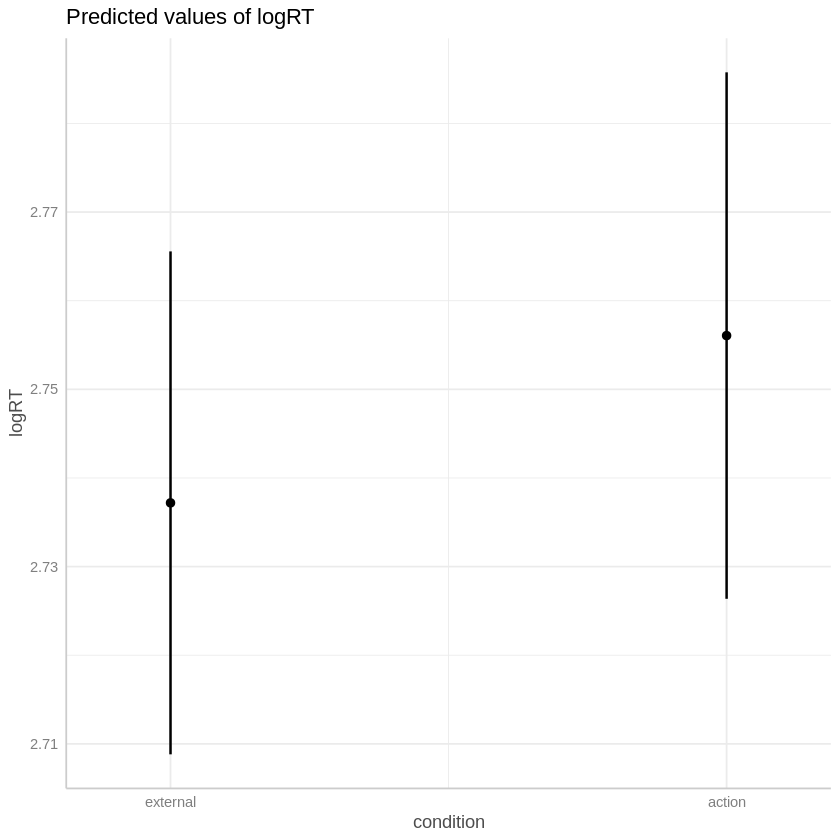

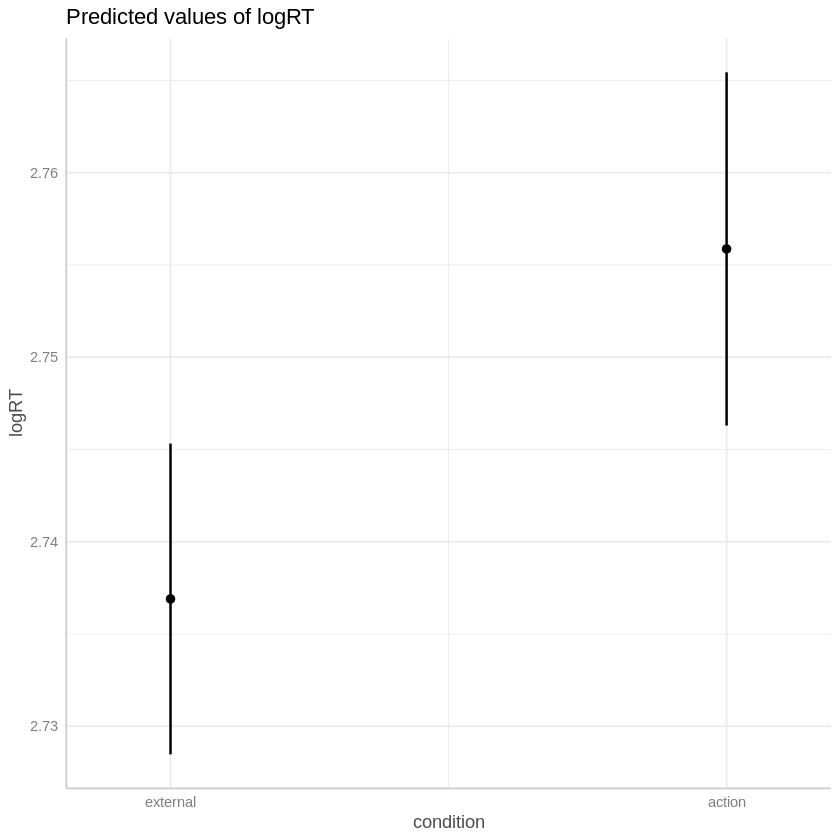

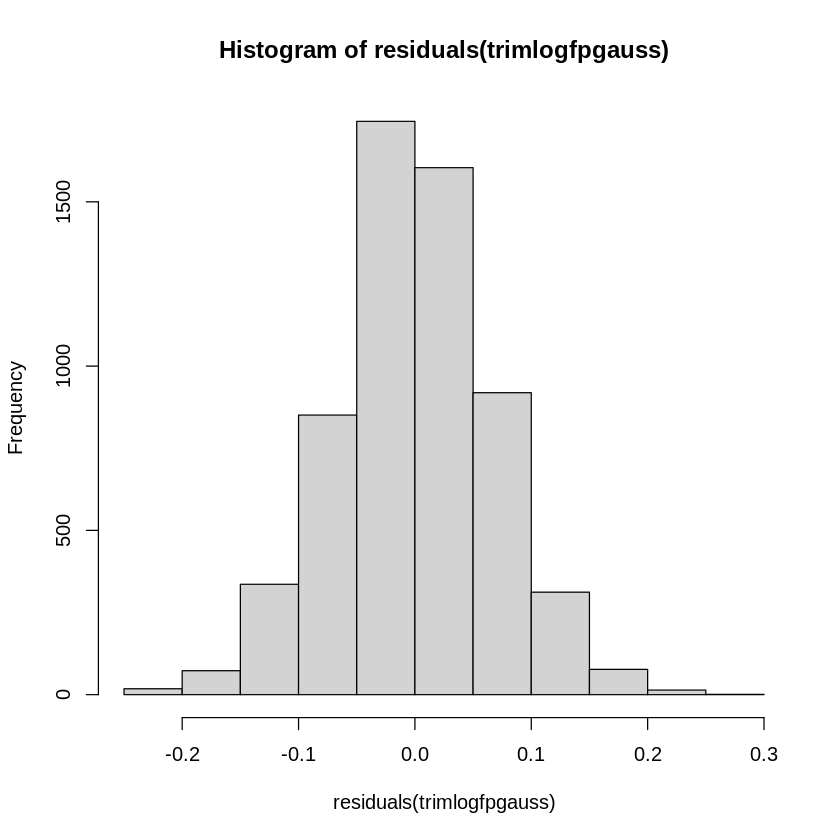

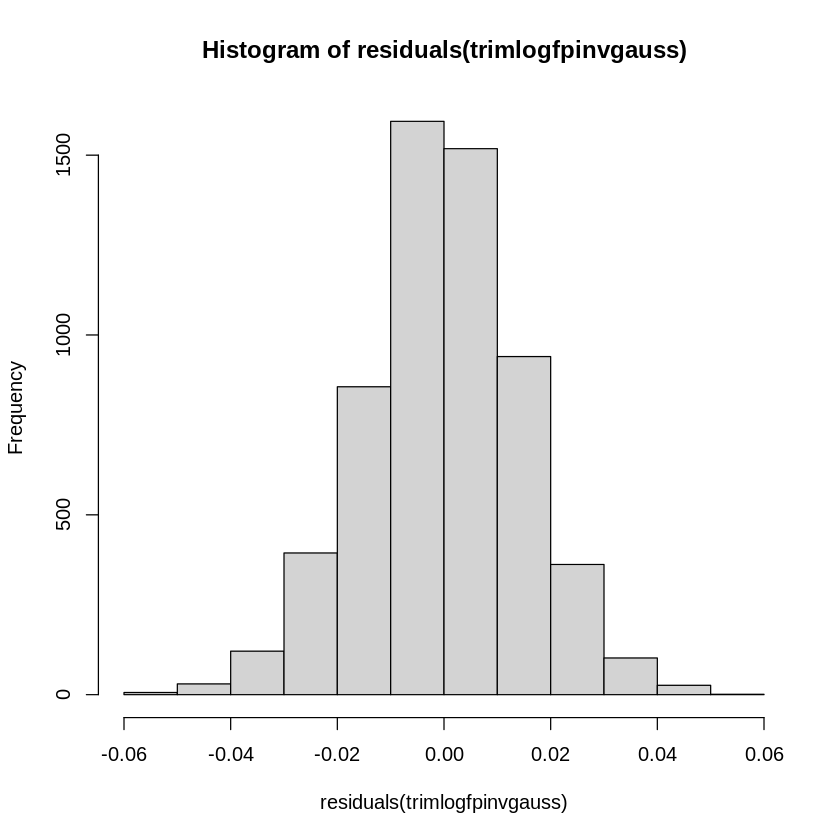

In [ ]:
# Compare visualizations
ggpredict(model = trimlogfpgauss,
          terms = "numForeperiod",
          type = 'fe') %>%
  plot()

ggpredict(model = trimlogfpinvgauss,
          terms = "numForeperiod",
          type = 'fe') %>%
  plot()

ggpredict(model = trimlogfpgauss,
          terms = "condition",
          type = 'fe') %>%
  plot()

ggpredict(model = trimlogfpinvgauss,
          terms = "condition",
          type = 'fe') %>%
  plot()

hist(residuals(trimlogfpgauss))
hist(residuals(trimlogfpinvgauss))

Even though the estimates are pretty similar, there is less variation for the inverse gaussian model.

### 4.3.2. Difference between the durations of FP n and FP n-1 as (numerical) predictor

Now we employ the difference between FP and FP n-1 as a numerical variable to compare with the results from the previous models.

In [ ]:
trimlogfpdifflmm1 <- buildmer(logRT ~ numForeperiod * condition * numOneBackFPDiff + 
                            (1+numForeperiod*condition*numOneBackFPDiff|ID), 
                          data=data2,
                          buildmerControl = buildmerControl(ddf = "Satterthwaite",
                                                            calc.anova = TRUE))#,
                                                            #args=list(control = lmerControl(optimizer = c('bobyqa')))))
formula(trimlogfpdifflmm1)

isSingular(trimlogfpdifflmm1)

The previous code successfully converges on a model with all interactions but that between foreperiod and the difference between FP n-1, and with a random intercept and random slope. The model does not show a singular fit, also. we can visualize the contents in the model:

In [ ]:
summary(trimlogfpdifflmm1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
logRT ~ 1 + condition + numForeperiod + numOneBackFPDiff + numForeperiod:numOneBackFPDiff +  
    condition:numOneBackFPDiff + (1 + condition | ID)
   Data: data2

REML criterion at convergence: -14919.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5609 -0.6266 -0.0096  0.6509  4.1414 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept) 0.004174 0.06461       
          condition1  0.001323 0.03637  -0.02
 Residual             0.004538 0.06736       
Number of obs: 5950, groups:  ID, 20

Fixed effects:
                                 Estimate Std. Error         df t value
(Intercept)                     2.757e+00  1.492e-02  2.146e+01 184.766
condition1                      1.902e-02  8.318e-03  1.899e+01   2.287
numForeperiod                  -7.919e-06  1.869e-06  5.906e+03  -4.238
numOneBackFPDiff               -2.428e-05  3.176e-06  5.

Just like in the previous analysis, the interaction between condition and FP n-1 is significant, which is is nice.

In [ ]:
install.packages("sjPlot")
library(sjPlot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘effectsize’, ‘parameters’, ‘sjlabelled’, ‘sjmisc’, ‘sjstats’




In [ ]:
install.packages("prediction")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
trimlogfpdifflmm1 <- mixed(formula = logRT ~ 1 + condition + numForeperiod + numOneBackFPDiff + numForeperiod:numOneBackFPDiff + 
    condition:numOneBackFPDiff + (1 + condition | ID),
                       data = data2,
                       control = lmerControl(optimizer = c("bobyqa"),optCtrl=list(maxfun=2e5),calc.derivs = FALSE),
                       progress = TRUE,
                       expand_re = TRUE,
                       method =  'KR',
                       return = "merMod")

[[1]]

[[2]]


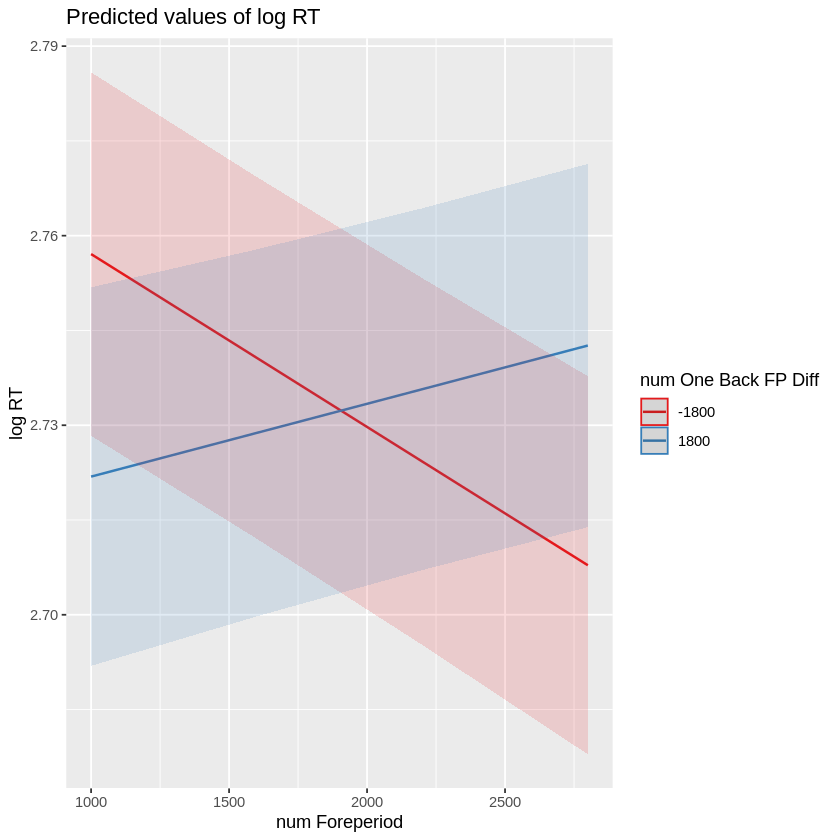

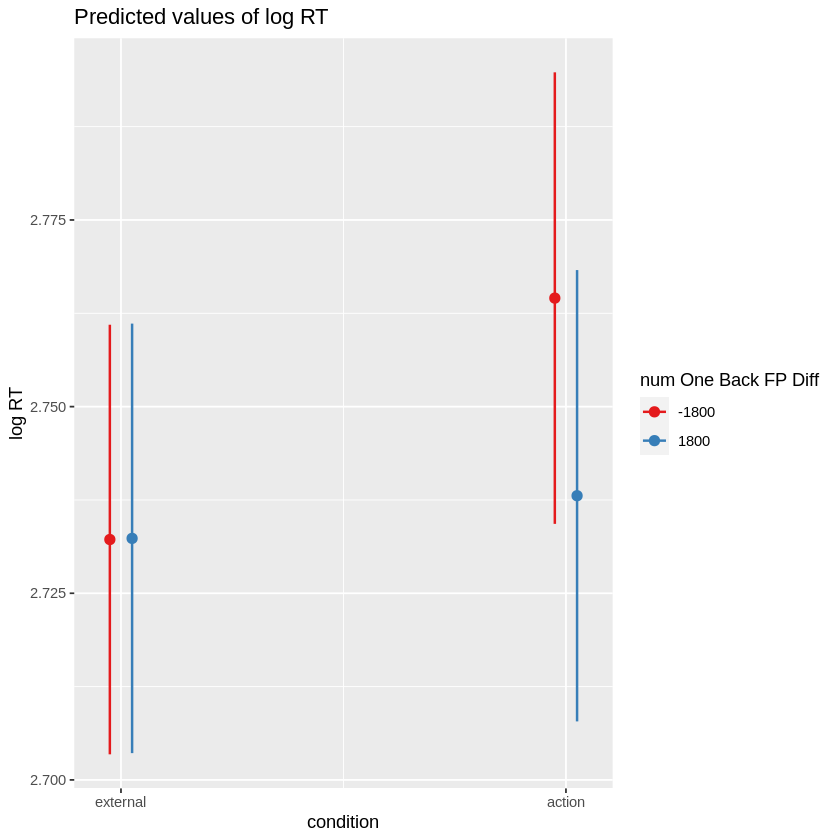

In [ ]:
plot_model(trimlogfpdifflmm1, type = "int", terms = c(condition,numOneBackFPDiff), ci.lvl = 0.95)

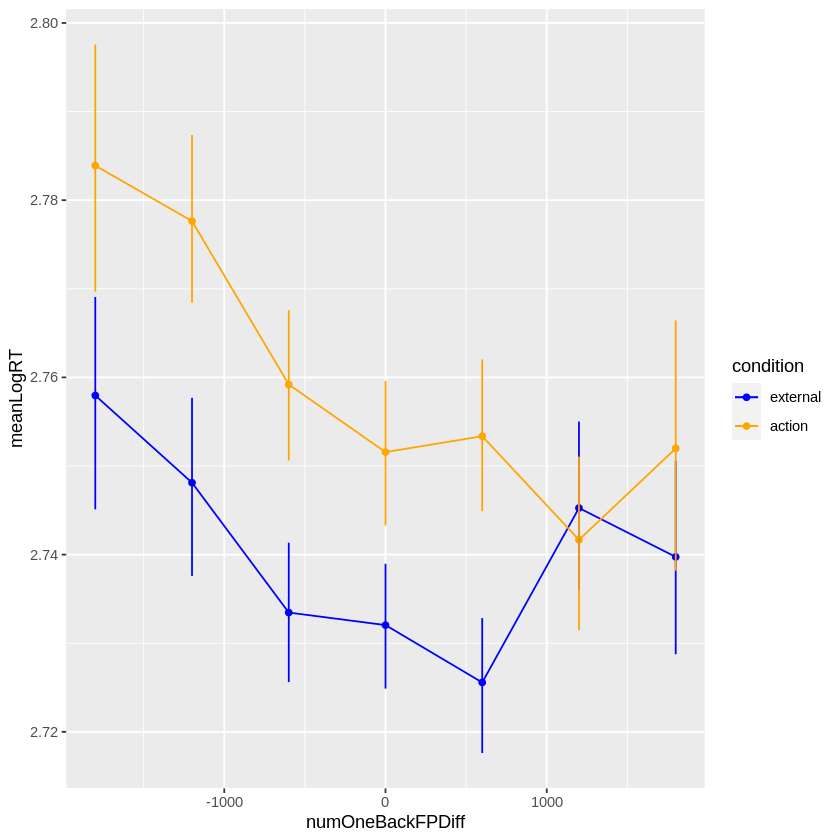

In [ ]:
ggplot(data=summaryData2,
aes(x=numOneBackFPDiff,
y=meanLogRT,
color=condition)) +
  stat_summary(fun='mean', geom='point') +
  stat_summary(fun='mean', geom='line', aes(group=condition)) +
  stat_summary(fun.data='mean_cl_boot', geom='errorbar', width=0.2) +
  scale_color_manual(values = c('orange','blue'))


In [ ]:
library(emmeans)

In [ ]:
emm_BlockLogTarget <- emtrends(trimlogfpdifflmm1, "condition", var = "numOneBackFPDiff", pbktest.limit=20000)
print(emm_BlockLogTarget) # Inclui esta linha para a gente ver o slope em cada bloco
print(update(pairs(emm_BlockLogTarget), by = NULL, adjust = "holm"))

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 5950' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 5950)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 5950' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 5950)' or larger];
but be warned that this may result in large computation time and memory use.



 condition numOneBackFPDiff.trend       SE  df asymp.LCL asymp.UCL
 external                4.21e-08 1.57e-06 Inf -3.03e-06  3.12e-06
 action                 -7.35e-06 1.61e-06 Inf -1.05e-05 -4.20e-06

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
 contrast          estimate       SE  df z.ratio p.value
 external - action 7.39e-06 1.82e-06 Inf   4.066  <.0001

Degrees-of-freedom method: asymptotic 
